# UMSCC Deep Learning

## Setting up environment

In [ ]:
pip install torchinfo

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset, ChainDataset
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchinfo import summary
from sklearn.model_selection import KFold
from PIL import Image
import sys

print('Pytorch version: ', torch.__version__)
print('GPU availability: ', torch.cuda.is_available())

Pytorch version:  2.0.0+cpu
GPU availability:  False


In [ ]:
if 'google.colab' in sys.modules:
  !unzip /content/drive/MyDrive/DL\ Model\ Data/Upload.zip
else:
  %cd C:\\Users\\jdivers\\Desktop\\ML_Model_Data

C:\Users\jdivers\Desktop\ML_Model_Data


In [ ]:
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()


## Define Dataset

In [ ]:
# Define dataset
class UMSCCDataset():
  def __init__(self, root, order, transform = None, augment = True):
    self.root = root
    self.transform = transform
    self.augment = augment
    self.order = order
    if self.order == ['all']:
      self.order = ['NADH', 'FAD', 'G', 'S', 'ORR', 'Photons', 'Tau1', 'Tau2', 'Alpha Ratio']
    self.stackheight = len(self.order)

    images = []
    labels = []
    self.samples = []
    self.modality = []

    ##############################
    ## Get metadata for samples ##
    ##############################
    if not self.augment:
      for animal in os.listdir(self.root):
        for sample in os.listdir(self.root + os.sep + animal):
          for fov in os.listdir(self.root + os.sep + animal + os.sep + sample):
            # Get target
            route = self.root + os.sep + animal + os.sep + sample + os.sep + fov
            self.samples.append(route)
            if animal[0] == ('x' or 'X'):
              d = 0
            else:
              d = 1
            labels.append(d)

            ########################
            ## Stack input images ##
            ########################
            x = np.zeros((self.stackheight, 512, 512), dtype= np.float32)

            # Parse input order into readable modalities
            mode = []
            for name in self.order:
              if 'NADH' == name or 'nadh' == name: mode.append('nadh.tiff')
              elif 'FAD' == name or 'fad' == name: mode.append('fad.tiff')
              elif 'G' == name or 'g' == name: mode.append('G.tiff')
              elif 'S' == name or 's' == name: mode.append('S.tiff')
              elif 'orr' == name or 'ORR' == name: mode.append('orr.tiff')
              elif 'photons' == name or 'Photons' == name or 'int' == name: mode.append('photons.tiff')
              elif 'tau1' == name or 'Tau1' == name or 't1' == name or 'T1' == name: mode.append('t1.tiff')
              elif 'tau2' == name or 'Tau2' == name or 't2' == name or 'T2' == name: mode.append('t2.tiff')
              elif 'alpha ratio' == name or 'a ratio' == name or 'Alpha Ratio' == name or 'a1a2' == name or 'A1A2' == name or 'A1A2 ratio' == name: mode.append(['a1.tiff', 'a2.tiff'])
              else: assert('Unrecognized modality input in order variable')

            # Load stack
            for ii, tiff in enumerate(mode):
              if type(tiff) is list:
                layer1 = np.array(Image.open(route + os.sep + tiff[0]), dtype = np.float32)
                layer2 = np.array(Image.open(route + os.sep + tiff[1]), dtype = np.float32)
                mask =  (np.array(layer2) <= 0) | (np.array(layer1) < 0)
                layer2[mask] = 1
                layer1[mask] = 0
                layer = np.divide(layer1, layer2)
              else:
                layer = np.array(Image.open(route + os.sep + tiff), dtype=np.float32)
              x[ii, :, :] = layer
            images.append(x)

            self.modality = mode

      #################################
      ## Augment data set by tencrop ##
      #################################
    else:
      cropper = transforms.FiveCrop(256)
      for animal in os.listdir(self.root):
        for sample in os.listdir(self.root + os.sep + animal):
          for fov in os.listdir(self.root + os.sep + animal + os.sep + sample):
            # Get target
            route = self.root + os.sep + animal + os.sep + sample + os.sep + fov
            self.samples.append(route)
            if animal[0] == ('x' or 'X'):
              d = 0
            else:
              d = 1
            labels.extend(5*[d]) # Duplicate labels for augmented data

            ########################
            ## Stack input images ##
            ########################
            x = np.zeros((self.stackheight, 256, 256, 5), dtype= np.float32)

            mode = self.stackheight*[None]
            # Parse input order into readable modalities
            mode = []
            for name in self.order:
              if 'NADH' == name or 'nadh' == name: mode.append('nadh.tiff')
              elif 'FAD' == name or 'fad' == name: mode.append('fad.tiff')
              elif 'G' == name or 'g' == name: mode.append('G.tiff')
              elif 'S' == name or 's' == name: mode.append('S.tiff')
              elif 'orr' == name or 'ORR' == name: mode.append('orr.tiff')
              elif 'photons' == name or 'Photons' == name or 'int' == name: mode.append('photons.tiff')
              elif 'tau1' == name or 'Tau1' == name or 't1' == name or 'T1' == name: mode.append('t1.tiff')
              elif 'tau2' == name or 'Tau2' == name or 't2' == name or 'T2' == name: mode.append('t2.tiff')
              elif 'alpha ratio' == name or 'a ratio' == name or 'Alpha Ratio' == name or 'a1a2' == name or 'A1A2' == name or 'A1A2 ratio' == name: mode.append(['a1.tiff', 'a2.tiff'])
              else: assert('Unrecognized modality input in order variable')

            # Load stack
            for ii, tiff in enumerate(mode):
              if type(tiff) is list:
                layer1 = cropper(Image.open(route + os.sep + tiff[0]))
                layer2 = cropper(Image.open(route + os.sep + tiff[1]))
                for jj in range(5):
                  top = np.array(layer1[jj], dtype=np.float32)
                  bottom = np.array(layer2[jj], dtype=np.float32)
                  mask =  (top < 0) | (bottom <= 0)
                  top[mask] = 0
                  bottom[mask] = 1
                  out = np.divide(top, bottom)
                  x[ii, :, :, jj] = np.array(out, dtype=np.float32)
              else:
                layer = cropper(Image.open(route + os.sep + tiff))
                for jj in range(5):
                  x[ii, :, :, jj] = np.asarray(layer[jj], dtype=np.float32)
            for kk in range(5):
              images.append(x[:,:,:,kk])

            self.modality.extend(5*[mode])

    # Convert and scale down by 8-bit and remove negatives
    images = np.array(images)
    images = images/255
    images[images<0] = 0

    self.images = images
    self.labels = np.array(labels, dtype=np.float32)
    self.dataset_size = len(self.images)

  def __len__(self):
    return self.dataset_size

  def __getitem__(self, index):
    img = torch.from_numpy(self.images[index])
    lab = self.labels[index]
    return img, lab

  def show_random(self):
    transform = transforms.Compose([transforms.ToPILImage()])
    f, ax = plt.subplots(5, len(self.order), figsize=(7, 7))
    for ii in range(5):
      index = np.random.randint(0, len(self))
      for jj in range(len(self.order)):
        ax[ii, jj].imshow(transform(self.images[index, jj, :, :]*255))
        ax[ii, jj].tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
        ax[ii, jj].set_title(f'Label: {self.labels[index]}. Mode: {self.order[jj]}', fontsize=10)
    plt.show()

  def norm_to_max(self):
    self.images = self.images/np.max(self.images)

### Transform
...image data to chain of histogram distributions

In [ ]:
# Define dataset
class UMSCC_Dist_Dataset():
  def __init__(self, root, order, bins = 25, augment = True):
    self.root = root
    self.augment = augment
    self.order = order
    self.bins = bins
    if self.order == ['all']:
      self.order = ['NADH', 'FAD', 'G', 'S', 'ORR', 'Photons', 'Tau1', 'Tau2', 'Alpha Ratio']
    self.stackheight = len(self.order)

    images = []
    labels = []
    self.samples = []
    self.modality = []

    ##############################
    ## Get metadata for samples ##
    ##############################
    if not self.augment:
      for animal in os.listdir(self.root):
        for sample in os.listdir(self.root + os.sep + animal):
          for fov in os.listdir(self.root + os.sep + animal + os.sep + sample):
            # Get target
            route = self.root + os.sep + animal + os.sep + sample + os.sep + fov
            self.samples.append(route)
            if animal[0] == ('x' or 'X'):
              d = 0
            else:
              d = 1
            labels.append(d)

            ########################
            ## Stack input images ##
            ########################
            x = np.zeros((self.stackheight, 512, 512), dtype= np.float32)

            # Parse input order into readable modalities
            mode = []
            for name in self.order:
              if 'NADH' == name or 'nadh' == name: mode.append('nadh.tiff')
              elif 'FAD' == name or 'fad' == name: mode.append('fad.tiff')
              elif 'G' == name or 'g' == name: mode.append('G.tiff')
              elif 'S' == name or 's' == name: mode.append('S.tiff')
              elif 'orr' == name or 'ORR' == name: mode.append('orr.tiff')
              elif 'photons' == name or 'Photons' == name or 'int' == name: mode.append('photons.tiff')
              elif 'tau1' == name or 'Tau1' == name or 't1' == name or 'T1' == name: mode.append('t1.tiff')
              elif 'tau2' == name or 'Tau2' == name or 't2' == name or 'T2' == name: mode.append('t2.tiff')
              elif 'alpha ratio' == name or 'a ratio' == name or 'Alpha Ratio' == name or 'a1a2' == name or 'A1A2' == name or 'A1A2 ratio' == name: mode.append(['a1.tiff', 'a2.tiff'])
              else: assert('Unrecognized modality input in order variable')

            # Load stack
            for ii, tiff in enumerate(mode):
              if type(tiff) is list:
                layer1 = np.array(Image.open(route + os.sep + tiff[0]), dtype = np.float32)
                layer2 = np.array(Image.open(route + os.sep + tiff[1]), dtype = np.float32)
                mask =  (np.array(layer2) <= 0) | (np.array(layer1) < 0)
                layer2[mask] = 1
                layer1[mask] = 0
                layer = np.divide(layer1, layer2)
              else:
                layer = np.array(Image.open(route + os.sep + tiff), dtype=np.float32)
              x[ii, :, :] = layer
            images.append(x)

            self.modality = mode

      #################################
      ## Augment data set by FiveCrop ##
      #################################
    else:
      cropper = transforms.FiveCrop(256)
      for animal in os.listdir(self.root):
        for sample in os.listdir(self.root + os.sep + animal):
          for fov in os.listdir(self.root + os.sep + animal + os.sep + sample):
            # Get target
            route = self.root + os.sep + animal + os.sep + sample + os.sep + fov
            self.samples.append(route)
            if animal[0] == ('x' or 'X'):
              d = 0
            else:
              d = 1
            labels.extend(5*[d]) # Duplicate labels for augmented data

            ########################
            ## Stack input images ##
            ########################
            x = np.zeros((self.stackheight, 256, 256, 5), dtype= np.float32)

            mode = self.stackheight*[None]
            # Parse input order into readable modalities
            mode = []
            for name in self.order:
              if 'NADH' == name or 'nadh' == name: mode.append('nadh.tiff')
              elif 'FAD' == name or 'fad' == name: mode.append('fad.tiff')
              elif 'G' == name or 'g' == name: mode.append('G.tiff')
              elif 'S' == name or 's' == name: mode.append('S.tiff')
              elif 'orr' == name or 'ORR' == name: mode.append('orr.tiff')
              elif 'photons' == name or 'Photons' == name or 'int' == name: mode.append('photons.tiff')
              elif 'tau1' == name or 'Tau1' == name or 't1' == name or 'T1' == name: mode.append('t1.tiff')
              elif 'tau2' == name or 'Tau2' == name or 't2' == name or 'T2' == name: mode.append('t2.tiff')
              elif 'alpha ratio' == name or 'a ratio' == name or 'Alpha Ratio' == name or 'a1a2' == name or 'A1A2' == name or 'A1A2 ratio' == name: mode.append(['a1.tiff', 'a2.tiff'])
              else: assert('Unrecognized modality input in order variable')

            # Load stack
            for ii, tiff in enumerate(mode):
              if type(tiff) is list:
                layer1 = cropper(Image.open(route + os.sep + tiff[0]))
                layer2 = cropper(Image.open(route + os.sep + tiff[1]))
                for jj in range(5):
                  top = np.array(layer1[jj], dtype=np.float32)
                  bottom = np.array(layer2[jj], dtype=np.float32)
                  mask =  (top < 0) | (bottom <= 0)
                  top[mask] = 0
                  bottom[mask] = 1
                  out = np.divide(top, bottom)
                  x[ii, :, :, jj] = np.array(out, dtype=np.float32)
              else:
                layer = cropper(Image.open(route + os.sep + tiff))
                for jj in range(5):
                  x[ii, :, :, jj] = np.asarray(layer[jj], dtype=np.float32)
            for kk in range(5):
              images.append(x[:,:,:,kk])

            self.modality.extend(5*[mode])

    # Convert and scale down by 8-bit and remove negatives
    images = np.array(images)
    images = images/255
    images[images<0] = 0

    self.images = images
    self.labels = np.array(labels, dtype=np.float32)
    self.dataset_size = len(self.images)
    self.im_dim = np.shape(self.images)[2:4]
    self.channels = np.shape(self.images)[1]

# Stack together histograms for each modality
    dist_data = np.empty((np.shape(self.images)[0], self.channels, self.bins), dtype=np.float32)
    for idx, img in enumerate(self.images):
      for ch, channel in enumerate(img):
        dist_data[idx, ch], _ = np.histogram(channel, bins=bins)
    self.dists = dist_data

  def __len__(self):
    return np.shape(self.dists)[0]

  def __getitem__(self, index):
    dist = torch.from_numpy(self.dists[index])
    lab = self.labels[index]
    return dist, lab

  def show_random(self):
    f, ax = plt.subplots(5, 1, figsize=(15, 15))
    for ii in range(5):
      index = np.random.randint(0, len(self))
      ax[ii].plot(self.dists[index].T, label=self.order)
      ax[ii].tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
      ax[ii].set_title(f'Label: {self.labels[index]}', fontsize=10)
      plt.legend()
    plt.show()

  # Method to convert pixel counts to pixel fracitons of total image size
  def normalize(self):
    self.dists = np.float32(self.dists/np.prod(self.im_dim))

## Helper Functions

In [ ]:
def outdim(in_dim_size):
  out_dim_size = np.floor((in_dim_size-2)/2)
  return int(out_dim_size)

In [ ]:
def train_epoch(model, loader, loss_fun, optimizer):
  model.train()
  total_loss = 0
  for batch_idx, (x, target) in enumerate(loader):
    if torch.cuda.is_available():
      x, target = x.cuda(), target.cuda()
    optimizer.zero_grad()
    out = model(x)
    loss = loss_fun(out, target.unsqueeze(-1))
    total_loss += loss.item()
    loss.backward()
    optimizer.step()
  epoch_loss = total_loss/len(loader.sampler)
  return epoch_loss

In [ ]:
def valid_epoch(model, loader, loss_fun):
  model.eval()
  with torch.no_grad():
    correct, total_loss = 0, 0
    for batch_idx, (x, target) in enumerate(loader):
      if torch.cuda.is_available():
        x, target = x.cuda(), target.cuda()
      out = model(x)
      loss = loss_fun(out, target.unsqueeze(-1))
      total_loss += loss.item()
      prediction = torch.round(out)
      correct += (prediction == target.unsqueeze(-1)).sum().item()
    val_loss = total_loss/len(loader.sampler)
    val_accu = correct/len(loader.sampler)
    return val_loss, val_accu

## Define Models

### Simple MLP

In [ ]:
class MLPNet(nn.Module):
  def __init__(self, input_size):
    super(MLPNet, self).__init__()
    self.input_size = input_size
    self.input_nodes = np.prod(self.input_size)

    self.flat = nn.Flatten()
    self.fc1 = nn.Linear(self.input_nodes, 100)
    self.out = nn.Linear(100, 1)

    self.relu1 = nn.ReLU()
    self.sigm = nn.Sigmoid()

  def forward(self, x):
    x = self.flat(x)
    x = self.fc1(x)
    x = self.relu1(x)
    x = self.out(x)
    x = self.sigm(x)
    return x

  def name(self):
    return "MLP"

### Regularized MLP

In [ ]:
class regMLPNet(nn.Module):
  def __init__(self, input_size):
    super(regMLPNet, self).__init__()
    self.input_size = input_size
    self.input_nodes = np.prod(self.input_size)
    self.flat = nn.Flatten()
    self.bn = nn.BatchNorm1d(self.input_nodes)
    self.fc1 = nn.Linear(self.input_nodes, 512)
    self.fc2 = nn.Linear(512, 512)
    self.fc3 = nn.Linear(512, 1)

    self.drop = nn.Dropout(0.25)
    self.relu = nn.ReLU()
    self.sigm = nn.Sigmoid()

  def forward(self, x):
    x = self.flat(x)
    x = self.bn(x)
    x = self.drop(x)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.drop(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.fc3(x)
    x = self.sigm(x)
    return x

  def name(self):
    return "regMLP"

### CNN

In [ ]:
class CNNet(nn.Module):
  def __init__(self, input_size):
    super(CNNet, self).__init__()
    self.input_size = input_size
    self.input_nodes = np.prod(self.input_size)
    self.input_channels = input_size[0]
    self.hout = outdim(outdim(outdim(outdim(outdim(self.input_size[1])))))
    self.wout = outdim(outdim(outdim(outdim(outdim(self.input_size[2])))))

    self.conv1 = nn.Conv2d(self.input_channels, 16, 3)
    self.conv2 = nn.Conv2d(16, 32, 3)
    self.conv3 = nn.Conv2d(32, 64, 3)
    self.conv4 = nn.Conv2d(64, 64, 3)
    self.conv5 = nn.Conv2d(64, 64, 3)

    self.flat = nn.Flatten()

    self.fc1 = nn.Linear(np.prod((64, self.hout, self.wout)), 512)
    self.fc2 = nn.Linear(512, 1)

    self.max = nn.MaxPool2d(2)
    self.relu = nn.ReLU()
    self.sigm = nn.Sigmoid()


  def forward(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.max(x)
    x = self.conv2(x)
    x = self.relu(x)
    x = self.max(x)
    x = self.conv3(x)
    x = self.relu(x)
    x = self.max(x)
    x = self.conv4(x)
    x = self.relu(x)
    x = self.max(x)
    x = self.conv5(x)
    x = self.relu(x)
    x = self.max(x)
    x = self.flat(x)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.sigm(x)
    return x

### Regularized CNN

In [ ]:
class regCNNet(nn.Module):
  def __init__(self, input_size):
    super(regCNNet, self).__init__()
    self.input_size = input_size
    self.input_nodes = np.prod(self.input_size)
    self.input_channels = input_size[0]
    self.hout = outdim(outdim(outdim(outdim(outdim(self.input_size[1])))))
    self.wout = outdim(outdim(outdim(outdim(outdim(self.input_size[2])))))

    self.bn = nn.BatchNorm2d(self.input_size[0])

    self.conv1 = nn.Conv2d(self.input_channels, 16, 3)
    self.conv2 = nn.Conv2d(16, 32, 3)
    self.conv3 = nn.Conv2d(32, 64, 3)
    self.conv4 = nn.Conv2d(64, 64, 3)
    self.conv5 = nn.Conv2d(64, 64, 3)

    self.flat = nn.Flatten()

    self.fc1 = nn.Linear(np.prod((64, self.hout, self.wout)), 512)
    self.fc2 = nn.Linear(512, 1)

    self.max = nn.MaxPool2d(2)
    self.drop = nn.Dropout(0.5)

    self.relu = nn.ReLU()
    self.sigm = nn.Sigmoid()


  def forward(self, x):
    x = self.bn(x)
    x = self.drop(x)
    x = self.conv1(x)
    x = self.relu(x)
    x = self.max(x)
    x = self.drop(x)
    x = self.conv2(x)
    x = self.relu(x)
    x = self.max(x)
    x = self.drop(x)
    x = self.conv3(x)
    x = self.relu(x)
    x = self.max(x)
    x = self.drop(x)
    x = self.conv4(x)
    x = self.relu(x)
    x = self.max(x)
    x = self.drop(x)
    x = self.conv5(x)
    x = self.relu(x)
    x = self.max(x)
    x = self.flat(x)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.sigm(x)
    return x

### JNet

In [ ]:
class JNet(nn.Module):
  def __init__(self):
    super(JNet, self).__init__()
    self.bn = nn.BatchNorm2d(512, affine = False)
    self.ap = nn.AvgPool3d((5,5,1), stride = [4,4,1], padding = [2, 2, 0])
    self.fc1 = nn.Linear(128*128*8, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 128)
    self.fc4 = nn.Linear(128, 64)
    self.fc5 = nn.Linear(64, 32)
    self.fc6 = nn.Linear(32, 8)
    self.fc7 = nn.Linear(8, 2)

  def forward(self, x):
    x = self.bn(x) # Normalize channels
    x = self.ap(x) # Downsample each layer using average pooling
    x = x.view(-1, 128*128*8) # Flatten into a 1D vector
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = F.relu(self.fc5(x))
    x = F.relu(self.fc6(x))
    x = self.fc7(x)
    return x

  def name(self):
    return "JNet"

### RNN

In [ ]:
class RNNet(nn.Module):
  def __init__(self, input_size):
    super(RNNet, self).__init__()
    self.input_size = input_size
    self.hidden_size = 100
    self.output_size = 1

    self.rnn = nn.RNN(self.input_size[0], self.hidden_size, num_layers=1, batch_first=True, nonlinearity='relu')
    self.fc = nn.Linear(self.hidden_size, self.output_size)
    self.sigm = nn.Sigmoid()

  def forward(self, x):
    h0 = Variable(torch.zeros(1, x.size(0), self.hidden_size))
    x, hn = self.rnn(x, h0)
    x = self.fc(x[:,-1,:])
    x = self.sigm(x)
    return x

  def name(self):
    return "RNN"

# High LR and Low Epochs

## Setting up datasets for training

Using all controls dataset (for maximum size with minimal confouding variables)

In [ ]:
################################################################
# Create and standardize/normalize dataset                     #
################################################################
modes = ['all']
bins = 25

times = ['0hpt-Baseline', '1hpt', '24hpt', '48hpt']
treatment = ['NT']
set_list = []
sen_set, res_set = {}, {}
keys =[]

for tx in treatment:
  for t in times:
    key = (tx + '_' + t)
    dir_ext = os.sep + tx + os.sep + t
    try:
      sen_set[key] = UMSCC_Dist_Dataset('Stacks' + os.sep + '22B' + dir_ext, modes, bins=bins, augment=True)
      res_set[key] = UMSCC_Dist_Dataset('Stacks' + os.sep + '47' + dir_ext, modes, bins=bins, augment=True)
      sen_set[key].normalize()
      res_set[key].normalize()
      set_list.append(sen_set[key])
      set_list.append(res_set[key])
      keys.append(key)
    except Exception as e:
      print(f'Skipping {key}: {e}')

all_set = ConcatDataset(set_list)
data_shape = np.shape(set_list[0].dists)[1:]

In [ ]:
################################################################
# Final datset splits and dataloader instantiation             #
# This will be overwritten if K-Fold CV is called in training  #
################################################################
BATCH_SIZE = 16
train_size = int(0.75 * len(all_set))
val_size = int(0.2 * train_size)
test_size = len(all_set) - (train_size + val_size)
train_set, val_set, test_set = torch.utils.data.random_split(
    dataset=all_set,
    lengths=[train_size, val_size, test_size])

train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True)
val_loader = torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=BATCH_SIZE,
    shuffle=False)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=BATCH_SIZE,
    shuffle=False)

In [ ]:
##############################
## Print lengths of subsets ##
##############################
print('Training set size: ', len(train_set))
print('Validation set size: ', len(val_set))
print('Testing set size: ', len(test_set))

Training set size:  941
Validation set size:  188
Testing set size:  126


## Single Model training & testing
Training each model once and comparing test results

### Training

In [ ]:
################################################################
# Hyper parameters                                            #
################################################################
LR = 0.01 # learning rate
EPOCHS = 250 # number of epochs to train model
RESULTS = {}

#### Simple MLP Net
Flatten data into vector, one hidden layer with size=100, ReLU nonlinearity, and sigmoidactivation at final output.

In [ ]:
################################################################
# Create model
################################################################
if torch.cuda.is_available():
  model = MLPNet(data_shape).cuda()
else:
  model = MLPNet(data_shape)

modelPath = f'./{model.name()}.pth'
print(summary(model, input_size=(BATCH_SIZE,) + data_shape))

################################################################
# Create optimizer and criterion
################################################################
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)
criterion = nn.BCELoss()

Layer (type:depth-idx)                   Output Shape              Param #
MLPNet                                   [16, 1]                   --
├─Flatten: 1-1                           [16, 225]                 --
├─Linear: 1-2                            [16, 100]                 22,600
├─ReLU: 1-3                              [16, 100]                 --
├─Linear: 1-4                            [16, 1]                   101
├─Sigmoid: 1-5                           [16, 1]                   --
Total params: 22,701
Trainable params: 22,701
Non-trainable params: 0
Total mult-adds (M): 0.36
Input size (MB): 0.01
Forward/backward pass size (MB): 0.01
Params size (MB): 0.09
Estimated Total Size (MB): 0.12


C:\Users\jdivers\AppData\Local\Programs\Python\Python310\lib\site-packages\torchinfo\torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
C:\Users\jdivers\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


==>>> epoch: 0, train loss: 0.042521, val loss: 0.043958, val accuracy: 0.510638
==>>> epoch: 1, train loss: 0.042012, val loss: 0.043766, val accuracy: 0.510638
==>>> epoch: 2, train loss: 0.041331, val loss: 0.042792, val accuracy: 0.590426
==>>> epoch: 3, train loss: 0.040121, val loss: 0.041570, val accuracy: 0.654255
==>>> epoch: 4, train loss: 0.038947, val loss: 0.040657, val accuracy: 0.611702
==>>> epoch: 5, train loss: 0.037163, val loss: 0.039072, val accuracy: 0.664894
==>>> epoch: 6, train loss: 0.036009, val loss: 0.037890, val accuracy: 0.702128
==>>> epoch: 7, train loss: 0.035093, val loss: 0.037862, val accuracy: 0.648936
==>>> epoch: 8, train loss: 0.034168, val loss: 0.038436, val accuracy: 0.648936
==>>> epoch: 9, train loss: 0.033990, val loss: 0.035920, val accuracy: 0.723404
==>>> epoch: 10, train loss: 0.034071, val loss: 0.035564, val accuracy: 0.734043
==>>> epoch: 11, train loss: 0.033346, val loss: 0.034849, val accuracy: 0.744681
==>>> epoch: 12, train los

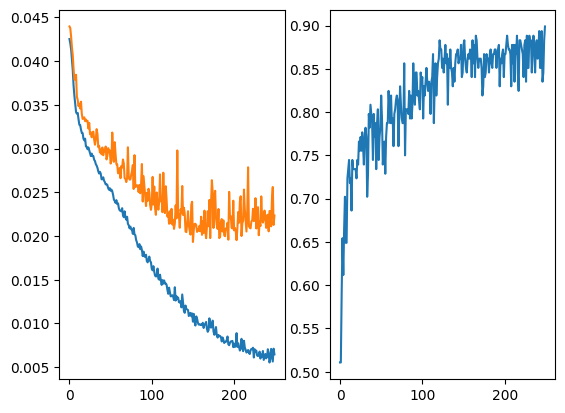

In [ ]:
tran_loss = []
eval_accu = []
eval_loss = []

for epoch in range(EPOCHS):
  epoch_loss = train_epoch(model, train_loader, criterion, optimizer)
  tran_loss.append(epoch_loss)

  val_loss, val_accu  = valid_epoch(model, val_loader, criterion)
  eval_loss.append(val_loss)
  eval_accu.append(val_accu)

  print(f'==>>> epoch: {epoch}, train loss: {tran_loss[-1]:.6f}, val loss: {eval_loss[-1]:.6f}, val accuracy: {eval_accu[-1]:.6f}')

  if epoch == 0:
    best_acc = eval_accu[-1]
    torch.save(model.state_dict(), modelPath)
  elif eval_accu[-1] > best_acc:
    torch.save(model.state_dict(), modelPath)
    best_acc = eval_accu[-1]

fig, ax = plt.subplots(1, 2)
ax[0].plot(tran_loss)
ax[0].plot(eval_loss)
ax[1].plot(eval_accu)

In [ ]:
################################################################
# Testing process
################################################################
model = MLPNet(data_shape)
modelPath = './' + model.name() + '.pth'
model.load_state_dict(torch.load(modelPath))

correct = 0
with torch.no_grad():
  model.eval()
  for batch_idx, (x, target) in enumerate(test_loader):
    if torch.cuda.is_available():
      x, target = x.cuda(), target.cuda()
    out = model(x)
    pred_label = torch.round(out)
    grou_truth = target.unsqueeze(-1)
    correct += (pred_label == grou_truth).sum().item()

accu = 100*correct/len(test_set)
RESULTS[model.name()] = accu

#### Regualrized MLP
Batch norm on input and dropouts at hiddne layer.



In [ ]:
################################################################
# Create model
################################################################
if torch.cuda.is_available():
  model = regMLPNet(data_shape).cuda()
else:
  model = regMLPNet(data_shape)

modelPath = f'./{model.name()}.pth'
print(summary(model, input_size=(BATCH_SIZE,) + data_shape))

################################################################
# Create optimizer and criterion
################################################################
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)
criterion = nn.BCELoss()

Layer (type:depth-idx)                   Output Shape              Param #
regMLPNet                                [16, 1]                   --
├─Flatten: 1-1                           [16, 225]                 --
├─BatchNorm1d: 1-2                       [16, 225]                 450
├─Dropout: 1-3                           [16, 225]                 --
├─Linear: 1-4                            [16, 512]                 115,712
├─ReLU: 1-5                              [16, 512]                 --
├─Dropout: 1-6                           [16, 512]                 --
├─Linear: 1-7                            [16, 512]                 262,656
├─ReLU: 1-8                              [16, 512]                 --
├─Linear: 1-9                            [16, 1]                   513
├─Sigmoid: 1-10                          [16, 1]                   --
Total params: 379,331
Trainable params: 379,331
Non-trainable params: 0
Total mult-adds (M): 6.07
Input size (MB): 0.01
Forward/backward pass s

==>>> epoch: 0, train loss: 0.038572, val loss: 0.037986, val accuracy: 0.734043
==>>> epoch: 1, train loss: 0.033045, val loss: 0.029542, val accuracy: 0.787234
==>>> epoch: 2, train loss: 0.029926, val loss: 0.027247, val accuracy: 0.819149
==>>> epoch: 3, train loss: 0.026490, val loss: 0.023306, val accuracy: 0.856383
==>>> epoch: 4, train loss: 0.024212, val loss: 0.020313, val accuracy: 0.872340
==>>> epoch: 5, train loss: 0.022299, val loss: 0.019209, val accuracy: 0.898936
==>>> epoch: 6, train loss: 0.022606, val loss: 0.019216, val accuracy: 0.877660
==>>> epoch: 7, train loss: 0.022047, val loss: 0.018463, val accuracy: 0.867021
==>>> epoch: 8, train loss: 0.020419, val loss: 0.018178, val accuracy: 0.867021
==>>> epoch: 9, train loss: 0.020813, val loss: 0.017525, val accuracy: 0.904255
==>>> epoch: 10, train loss: 0.019778, val loss: 0.016516, val accuracy: 0.898936
==>>> epoch: 11, train loss: 0.019547, val loss: 0.015866, val accuracy: 0.909574
==>>> epoch: 12, train los

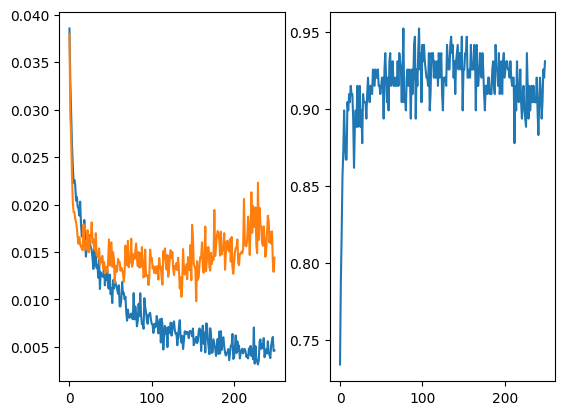

In [ ]:
tran_loss = []
eval_accu = []
eval_loss = []

for epoch in range(EPOCHS):
  epoch_loss = train_epoch(model, train_loader, criterion, optimizer)
  tran_loss.append(epoch_loss)

  val_loss, val_accu  = valid_epoch(model, val_loader, criterion)
  eval_loss.append(val_loss)
  eval_accu.append(val_accu)

  print(f'==>>> epoch: {epoch}, train loss: {tran_loss[-1]:.6f}, val loss: {eval_loss[-1]:.6f}, val accuracy: {eval_accu[-1]:.6f}')

  if epoch == 0:
    best_acc = eval_accu[-1]
    torch.save(model.state_dict(), modelPath)
  elif eval_accu[-1] > best_acc:
    torch.save(model.state_dict(), modelPath)
    best_acc = eval_accu[-1]

fig, ax = plt.subplots(1, 2)
ax[0].plot(tran_loss)
ax[0].plot(eval_loss)
ax[1].plot(eval_accu)

In [ ]:
################################################################
# Testing process
################################################################
model = regMLPNet(data_shape)
modelPath = './' + model.name() + '.pth'
model.load_state_dict(torch.load(modelPath))

total_loss = 0
correct = 0
with torch.no_grad():
  model.eval()
  for batch_idx, (x, target) in enumerate(test_loader):
    if torch.cuda.is_available():
      x, target = x.cuda(), target.cuda()
    out = model(x)
    pred_label = torch.round(out)
    grou_truth = target.unsqueeze(-1)
    correct += (pred_label == grou_truth).sum().item()

accu = 100*correct/len(test_set)
RESULTS[model.name()] = accu

#### RNN

In [ ]:
################################################################
# Create model
################################################################
if torch.cuda.is_available():
  model = RNNet(data_shape[::-1]).cuda()
else:
  model = RNNet(data_shape[::-1])

modelPath = f'./{model.name()}.pth'
print(summary(model, input_size=(BATCH_SIZE,) + data_shape))

################################################################
# Create optimizer and criterion
################################################################
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)
criterion = nn.BCELoss()

Layer (type:depth-idx)                   Output Shape              Param #
RNNet                                    [16, 1]                   --
├─RNN: 1-1                               [16, 9, 100]              12,700
├─Linear: 1-2                            [16, 1]                   101
├─Sigmoid: 1-3                           [16, 1]                   --
Total params: 12,801
Trainable params: 12,801
Non-trainable params: 0
Total mult-adds (M): 1.83
Input size (MB): 0.01
Forward/backward pass size (MB): 0.12
Params size (MB): 0.05
Estimated Total Size (MB): 0.18


==>>> epoch: 0, train loss: 0.042604, val loss: 0.044550, val accuracy: 0.500000
==>>> epoch: 1, train loss: 0.042546, val loss: 0.044256, val accuracy: 0.500000
==>>> epoch: 2, train loss: 0.042450, val loss: 0.044224, val accuracy: 0.515957
==>>> epoch: 3, train loss: 0.042386, val loss: 0.044049, val accuracy: 0.537234
==>>> epoch: 4, train loss: 0.042395, val loss: 0.044137, val accuracy: 0.526596
==>>> epoch: 5, train loss: 0.042285, val loss: 0.044165, val accuracy: 0.526596
==>>> epoch: 6, train loss: 0.042274, val loss: 0.044275, val accuracy: 0.521277
==>>> epoch: 7, train loss: 0.042214, val loss: 0.043946, val accuracy: 0.537234
==>>> epoch: 8, train loss: 0.042210, val loss: 0.044208, val accuracy: 0.531915
==>>> epoch: 9, train loss: 0.042139, val loss: 0.043896, val accuracy: 0.542553
==>>> epoch: 10, train loss: 0.042031, val loss: 0.043953, val accuracy: 0.537234
==>>> epoch: 11, train loss: 0.042016, val loss: 0.043742, val accuracy: 0.537234
==>>> epoch: 12, train los

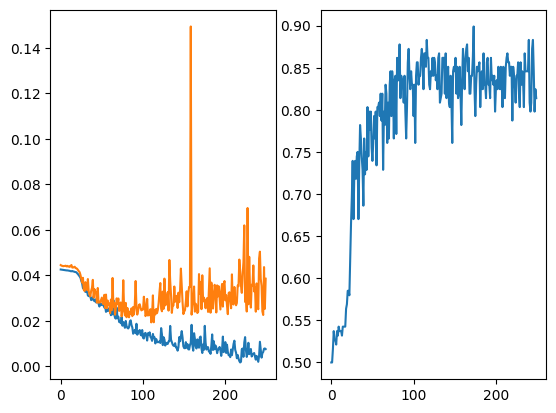

In [ ]:
tran_loss = []
eval_accu = []
eval_loss = []

for epoch in range(EPOCHS):
  epoch_loss = train_epoch(model, train_loader, criterion, optimizer)
  tran_loss.append(epoch_loss)

  val_loss, val_accu  = valid_epoch(model, val_loader, criterion)
  eval_loss.append(val_loss)
  eval_accu.append(val_accu)

  print(f'==>>> epoch: {epoch}, train loss: {tran_loss[-1]:.6f}, val loss: {eval_loss[-1]:.6f}, val accuracy: {eval_accu[-1]:.6f}')

  if epoch == 0:
    best_acc = eval_accu[-1]
    torch.save(model.state_dict(), modelPath)
  elif eval_accu[-1] > best_acc:
    torch.save(model.state_dict(), modelPath)
    best_acc = eval_accu[-1]

fig, ax = plt.subplots(1, 2)
ax[0].plot(tran_loss)
ax[0].plot(eval_loss)
ax[1].plot(eval_accu)

In [ ]:
################################################################
# Testing process
################################################################
model = RNNet(data_shape[::-1])
modelPath = './' + model.name() + '.pth'
model.load_state_dict(torch.load(modelPath))

total_loss = 0
correct = 0
with torch.no_grad():
  model.eval()
  for batch_idx, (x, target) in enumerate(test_loader):
    if torch.cuda.is_available():
      x, target = x.cuda(), target.cuda()
    out = model(x)
    pred_label = torch.round(out)
    grou_truth = target.unsqueeze(-1)
    correct += (pred_label == grou_truth).sum().item()

accu = 100*correct/len(test_set)
RESULTS[model.name()] = accu

### Results
With train, eval loop, svaing most accurate model in evaluation and testing on unseen dataset.

In [ ]:
for net in RESULTS:
  print(f'Accuracy for {net}: {RESULTS[net]:.2f}%')

Accuracy for MLP: 80.16%
Accuracy for regMLP: 87.30%
Accuracy for RNN: 84.92%


## 5-Fold Cross Validation Model Training & Testing
With train loop on fresh model and testing each fold on unseen dataset. Saving at each fold and collecting average results across models.

In [ ]:
FOLDS = 5
kfold = KFold(n_splits = FOLDS, shuffle = True)
kRESULTS = {}

### Training

#### Simple MLP

FOLD 1
___________________________
Accuracy for fold 1: 84.06%


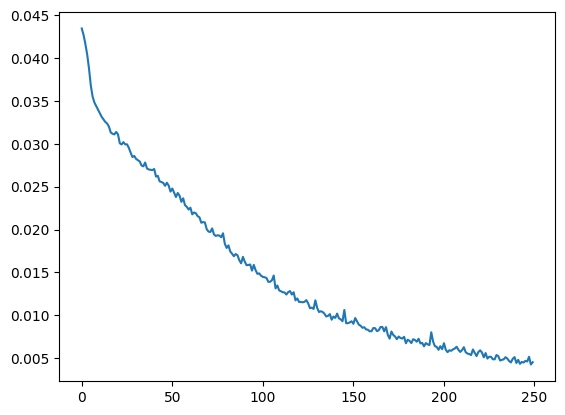

FOLD 2
___________________________
Accuracy for fold 2: 84.06%


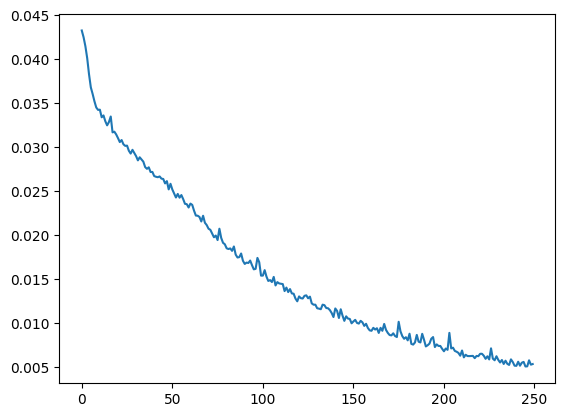

FOLD 3
___________________________
Accuracy for fold 3: 86.85%


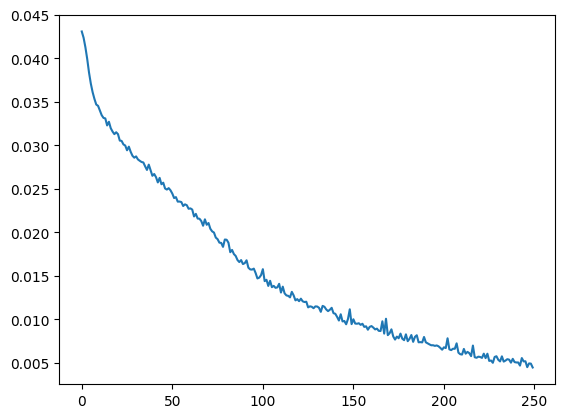

FOLD 4
___________________________
Accuracy for fold 4: 87.25%


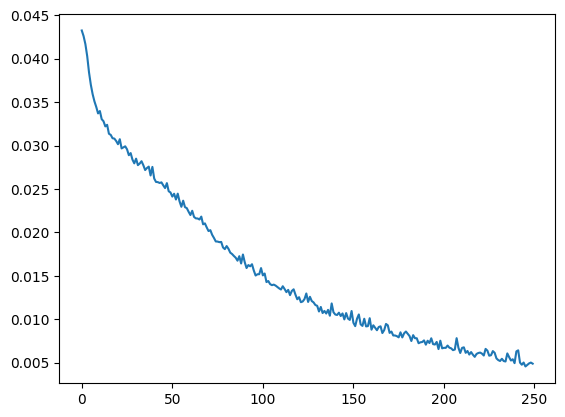

FOLD 5
___________________________
Accuracy for fold 5: 86.06%


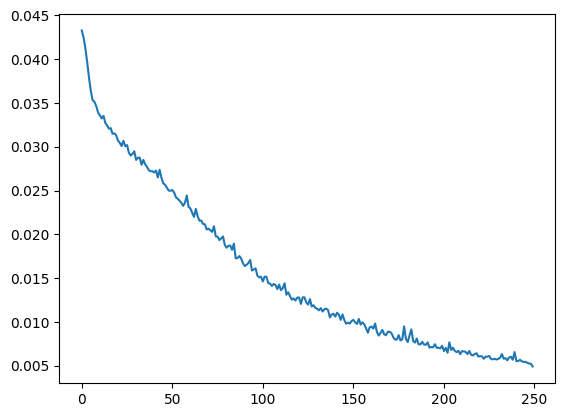

K-FOLD CV RESULTS FOR 5 FOLDS:
Average: 85.66%


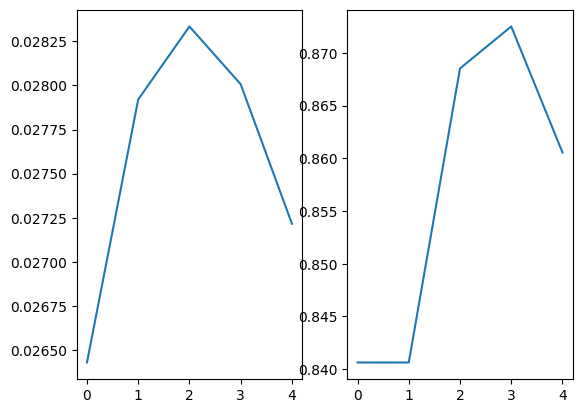

In [ ]:
################################################################
# Training process
################################################################
eval_loss = []
eval_accu = []
sum = 0.0

for fold, (train_ids, test_ids) in enumerate(kfold.split(np.arange(len(all_set)))):
  tran_loss = []
  print(f'FOLD {fold+1}')
  print('___________________________')

  # Create KFolds Dataloaders
  train_sampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_sampler = torch.utils.data.SubsetRandomSampler(test_ids)
  train_loader = torch.utils.data.DataLoader(all_set, batch_size=BATCH_SIZE, sampler=train_sampler)
  test_loader = torch.utils.data.DataLoader(all_set, batch_size=BATCH_SIZE, sampler=test_sampler)

  # Create/Reset model and optimzer for fold
  if torch.cuda.is_available():
    model = MLPNet(data_shape).cuda()
  else:
    model = MLPNet(data_shape)

  optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)

  for epoch in range(EPOCHS):
    epoch_loss = train_epoch(model, train_loader, criterion, optimizer)
    tran_loss.append(epoch_loss)

  val_loss, val_accu = valid_epoch(model, test_loader, criterion)
  eval_loss.append(val_loss)
  eval_accu.append(val_accu)

  key_name = f'{model.name()} Fold: {fold+1}'
  kRESULTS[key_name] = 100.0*val_accu
  print(f'Accuracy for fold {fold+1}: {kRESULTS[key_name]:.2f}%')
  modelPath = f'./{model.name()}_fold{fold+1}.pth'
  torch.save(model.state_dict(), modelPath)

  sum += val_accu

  plt.plot(tran_loss)
  plt.show()

fig, ax = plt.subplots(1,2)
ax[0].plot(eval_loss)
ax[1].plot(eval_accu)
print(f'K-FOLD CV RESULTS FOR {FOLDS} FOLDS:')

avgAccu = 100*sum/FOLDS
RESULTS[f'{model.name()} 5-Fold Avg'] = avgAccu
print(f'Average: {avgAccu:.2f}%')

#### Regularized MLP

FOLD 1
___________________________
Accuracy for fold 1: 90.44%


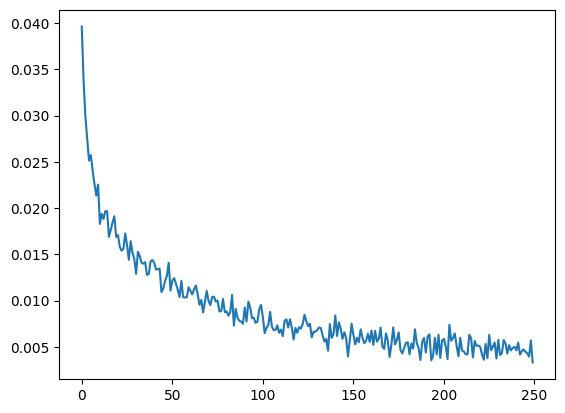

FOLD 2
___________________________
Accuracy for fold 2: 88.05%


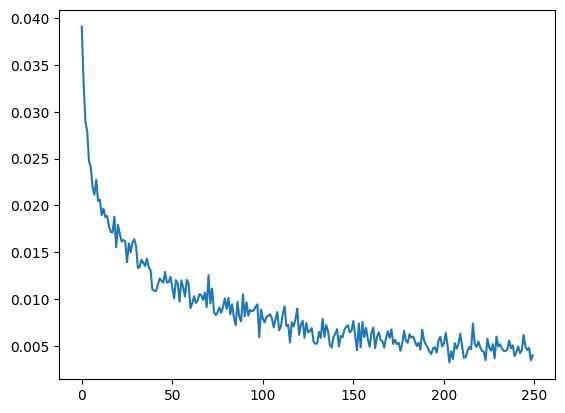

FOLD 3
___________________________
Accuracy for fold 3: 89.64%


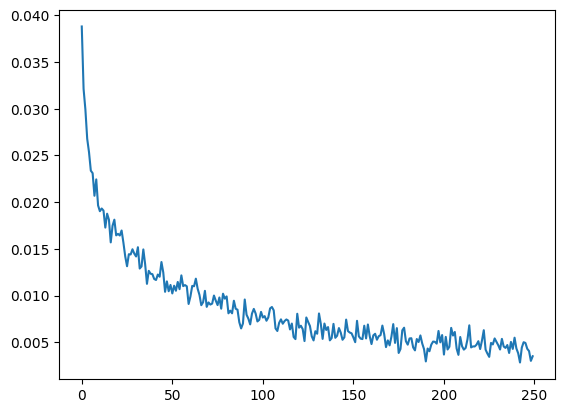

FOLD 4
___________________________
Accuracy for fold 4: 92.43%


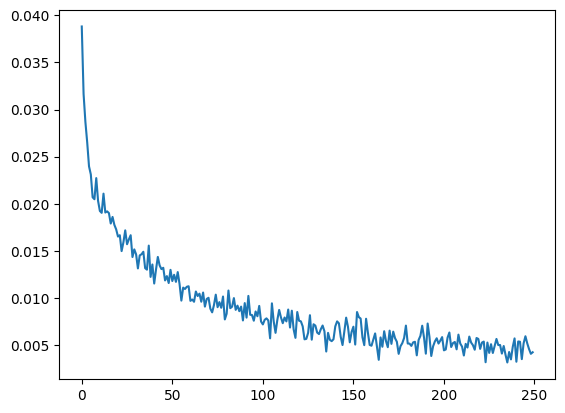

FOLD 5
___________________________
Accuracy for fold 5: 88.05%


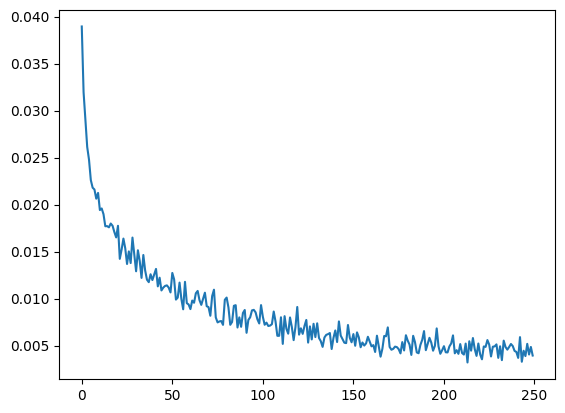

K-FOLD CV RESULTS FOR 5 FOLDS:
Average: 89.72%


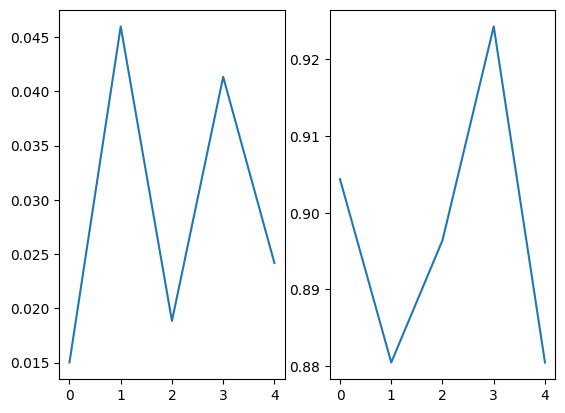

In [ ]:
################################################################
# Training process
################################################################
eval_loss = []
eval_accu = []
sum = 0.0

for fold, (train_ids, test_ids) in enumerate(kfold.split(np.arange(len(all_set)))):
  tran_loss = []
  print(f'FOLD {fold+1}')
  print('___________________________')

  # Create KFolds Dataloaders
  train_sampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_sampler = torch.utils.data.SubsetRandomSampler(test_ids)
  train_loader = torch.utils.data.DataLoader(all_set, batch_size=BATCH_SIZE, sampler=train_sampler)
  test_loader = torch.utils.data.DataLoader(all_set, batch_size=BATCH_SIZE, sampler=test_sampler)

  # Create/Reset model and optimzer for fold
  if torch.cuda.is_available():
    model = regMLPNet(data_shape).cuda()
  else:
    model = regMLPNet(data_shape)

  optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)

  for epoch in range(EPOCHS):
    epoch_loss = train_epoch(model, train_loader, criterion, optimizer)
    tran_loss.append(epoch_loss)

  val_loss, val_accu = valid_epoch(model, test_loader, criterion)
  eval_loss.append(val_loss)
  eval_accu.append(val_accu)

  key_name = f'{model.name()} Fold: {fold+1}'
  kRESULTS[key_name] = 100.0*val_accu
  print(f'Accuracy for fold {fold+1}: {kRESULTS[key_name]:.2f}%')
  modelPath = f'./{model.name()}_fold{fold+1}.pth'
  torch.save(model.state_dict(), modelPath)

  sum += val_accu

  plt.plot(tran_loss)
  plt.show()

fig, ax = plt.subplots(1,2)
ax[0].plot(eval_loss)
ax[1].plot(eval_accu)
print(f'K-FOLD CV RESULTS FOR {FOLDS} FOLDS:')

avgAccu = 100*sum/FOLDS
RESULTS[f'{model.name()} 5-Fold Avg'] = avgAccu
print(f'Average: {avgAccu:.2f}%')

#### RNN

FOLD 1
___________________________
Accuracy for fold 1: 85.66%


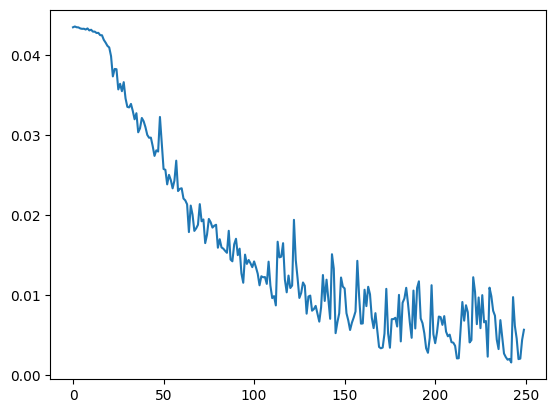

FOLD 2
___________________________
Accuracy for fold 2: 78.88%


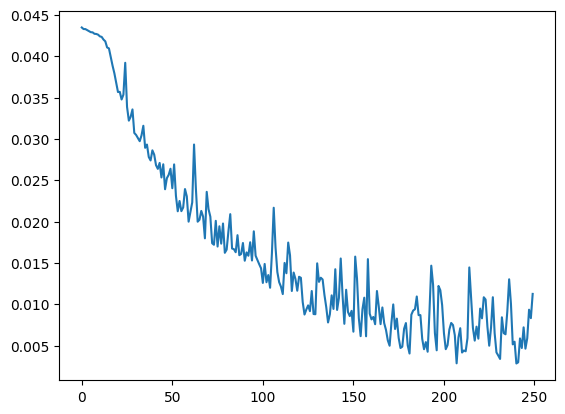

FOLD 3
___________________________
Accuracy for fold 3: 83.67%


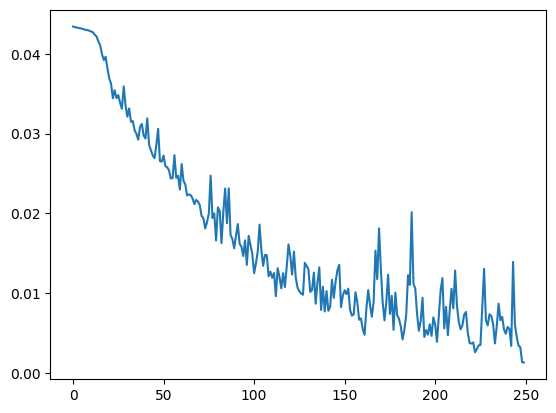

FOLD 4
___________________________
Accuracy for fold 4: 86.45%


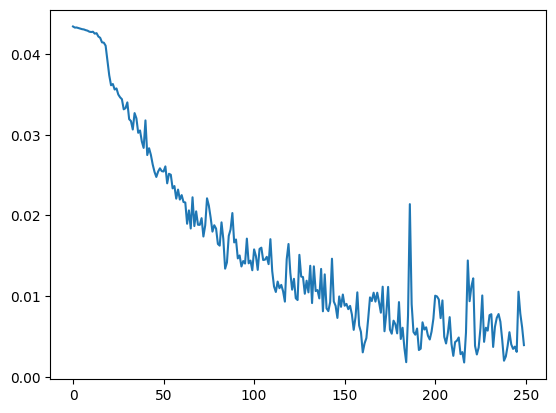

FOLD 5
___________________________
Accuracy for fold 5: 84.06%


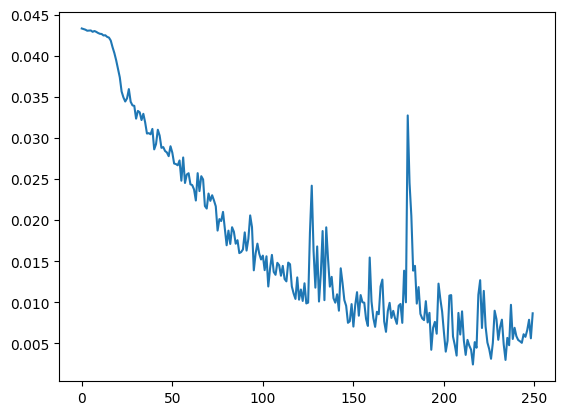

K-FOLD CV RESULTS FOR 5 FOLDS:
Average: 83.75%


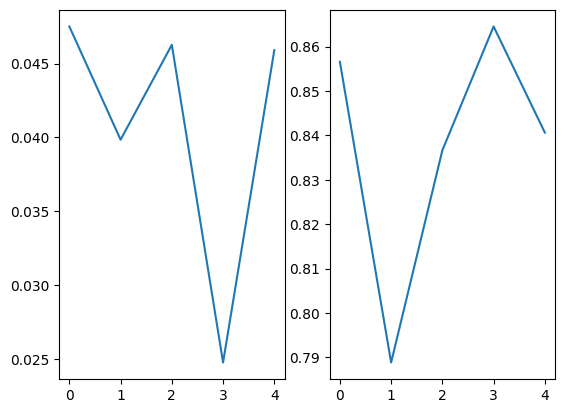

In [ ]:
################################################################
# Training process
################################################################
eval_loss = []
eval_accu = []
sum = 0.0

for fold, (train_ids, test_ids) in enumerate(kfold.split(np.arange(len(all_set)))):
  tran_loss = []
  print(f'FOLD {fold+1}')
  print('___________________________')

  # Create KFolds Dataloaders
  train_sampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_sampler = torch.utils.data.SubsetRandomSampler(test_ids)
  train_loader = torch.utils.data.DataLoader(all_set, batch_size=BATCH_SIZE, sampler=train_sampler)
  test_loader = torch.utils.data.DataLoader(all_set, batch_size=BATCH_SIZE, sampler=test_sampler)

  # Create/Reset model and optimzer for fold
  if torch.cuda.is_available():
    model = RNNet(data_shape[::-1]).cuda()
  else:
    model = RNNet(data_shape[::-1])

  optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)

  for epoch in range(EPOCHS):
    epoch_loss = train_epoch(model, train_loader, criterion, optimizer)
    tran_loss.append(epoch_loss)

  val_loss, val_accu = valid_epoch(model, test_loader, criterion)
  eval_loss.append(val_loss)
  eval_accu.append(val_accu)

  key_name = f'{model.name()} Fold: {fold+1}'
  kRESULTS[key_name] = 100.0*val_accu
  print(f'Accuracy for fold {fold+1}: {kRESULTS[key_name]:.2f}%')
  modelPath = f'./{model.name()}_fold{fold+1}.pth'
  torch.save(model.state_dict(), modelPath)

  sum += val_accu

  plt.plot(tran_loss)
  plt.show()

fig, ax = plt.subplots(1,2)
ax[0].plot(eval_loss)
ax[1].plot(eval_accu)
print(f'K-FOLD CV RESULTS FOR {FOLDS} FOLDS:')

avgAccu = 100*sum/FOLDS
RESULTS[f'{model.name()} 5-Fold Avg'] = avgAccu
print(f'Average: {avgAccu:.2f}%')

## Results from both training styles

In [ ]:
for net, accu in RESULTS.items():
  print(f'Accuracy for {net}: {accu:.2f}%')

Accuracy for MLP: 80.16%
Accuracy for regMLP: 87.30%
Accuracy for RNN: 84.92%
Accuracy for MLP 5-Fold Avg: 85.66%
Accuracy for regMLP 5-Fold Avg: 89.72%
Accuracy for RNN 5-Fold Avg: 83.75%


## Retesting 5-Fold CV with only 6 hyper-features
Excluding fit features from lifetime-based data

In [ ]:
################################################################
# Create and standardize/normalize dataset                     #
################################################################
modes = ['G', 'S', 'Photons', 'NADH', 'FAD', 'ORR']
times = ['0hpt-Baseline', '1hpt', '24hpt', '48hpt']
treatment = ['NT']
set_list = []
sen_set, res_set = {}, {}
keys =[]

for tx in treatment:
  for t in times:
    key = (tx + '_' + t)
    dir_ext = os.sep + tx + os.sep + t
    try:
      sen_set[key] = UMSCC_Dist_Dataset('Stacks/22B' + dir_ext, modes, bins=bins, augment=True)
      res_set[key] = UMSCC_Dist_Dataset('Stacks/47' + dir_ext, modes, bins=bins, augment=True)
      sen_set[key].normalize()
      res_set[key].normalize()
      set_list.append(sen_set[key])
      set_list.append(res_set[key])
      keys.append(key)
    except Exception as e:
      print(f'Skipping {key}: {e}')

all_set = ConcatDataset(set_list)
data_shape = np.shape(set_list[0].dists)[1:]

In [ ]:
################################################################
# Final datset splits and dataloader instantiation             #
# This will be overwritten if K-Fold CV is called in training  #
################################################################
BATCH_SIZE = 16
train_size = int(0.75 * len(all_set))
val_size = int(0.2 * train_size)
test_size = len(all_set) - (train_size + val_size)
train_set, val_set, test_set = torch.utils.data.random_split(
    dataset=all_set,
    lengths=[train_size, val_size, test_size])

train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=BATCH_SIZE,
    shuffle=True)
val_loader = torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=BATCH_SIZE,
    shuffle=False)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=BATCH_SIZE,
    shuffle=False)


### Training

#### Simple MLP

FOLD 1
___________________________
Accuracy for fold 1: 86.06%


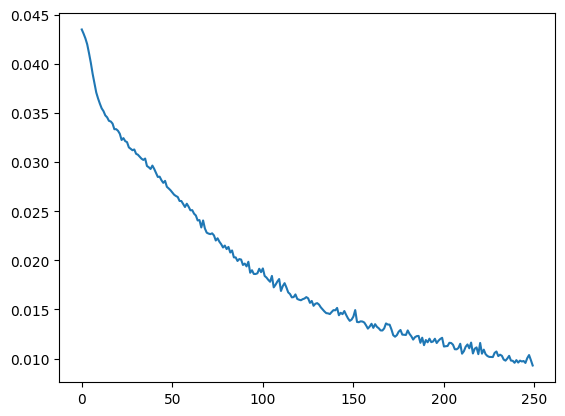

FOLD 2
___________________________
Accuracy for fold 2: 84.06%


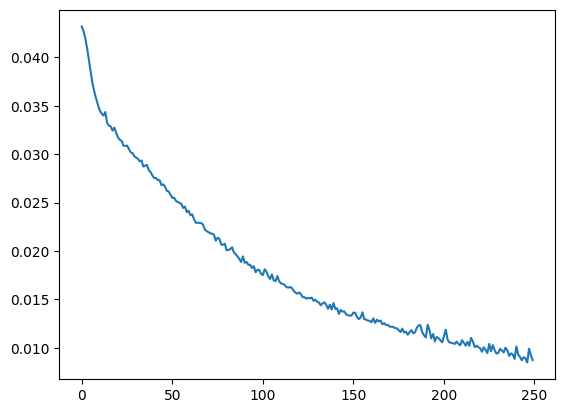

FOLD 3
___________________________
Accuracy for fold 3: 81.27%


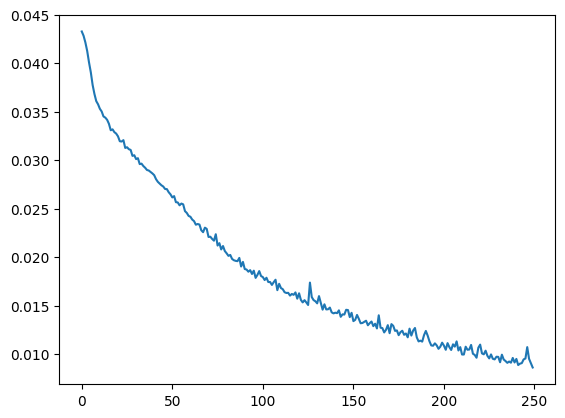

FOLD 4
___________________________
Accuracy for fold 4: 83.27%


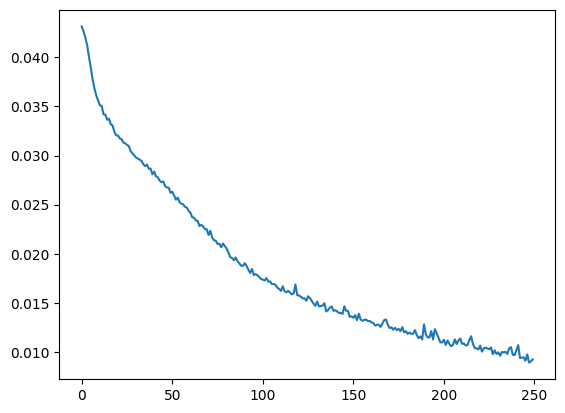

FOLD 5
___________________________
Accuracy for fold 5: 82.87%


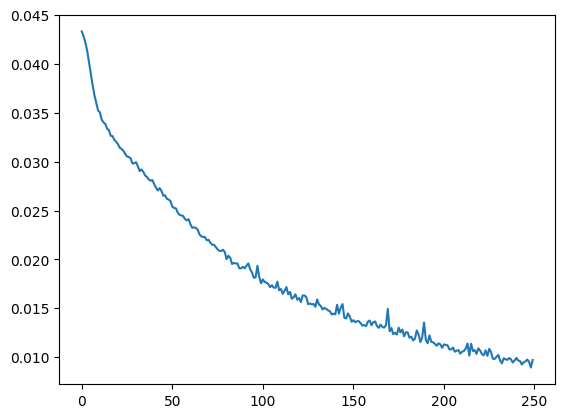

K-FOLD CV RESULTS FOR 5 FOLDS:
Average: 83.51%


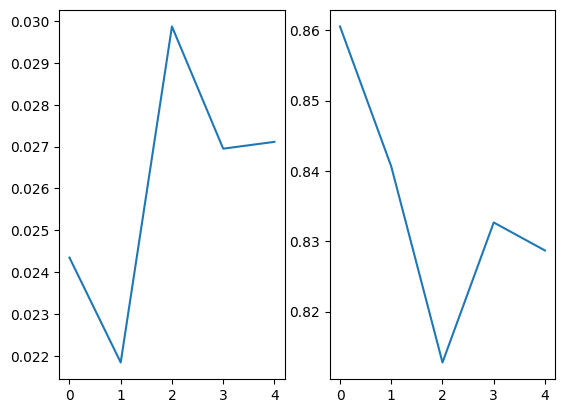

In [ ]:
################################################################
# Training process
################################################################
eval_loss = []
eval_accu = []
sum = 0.0

for fold, (train_ids, test_ids) in enumerate(kfold.split(np.arange(len(all_set)))):
  tran_loss = []
  print(f'FOLD {fold+1}')
  print('___________________________')

  # Create KFolds Dataloaders
  train_sampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_sampler = torch.utils.data.SubsetRandomSampler(test_ids)
  train_loader = torch.utils.data.DataLoader(all_set, batch_size=BATCH_SIZE, sampler=train_sampler)
  test_loader = torch.utils.data.DataLoader(all_set, batch_size=BATCH_SIZE, sampler=test_sampler)

  # Create/Reset model and optimzer for fold
  if torch.cuda.is_available():
    model = MLPNet(data_shape).cuda()
  else:
    model = MLPNet(data_shape)

  optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)

  for epoch in range(EPOCHS):
    epoch_loss = train_epoch(model, train_loader, criterion, optimizer)
    tran_loss.append(epoch_loss)

  val_loss, val_accu = valid_epoch(model, test_loader, criterion)
  eval_loss.append(val_loss)
  eval_accu.append(val_accu)

  key_name = f'{model.name()} Fold: {fold+1}'
  kRESULTS[key_name] = 100.0*val_accu
  print(f'Accuracy for fold {fold+1}: {kRESULTS[key_name]:.2f}%')
  modelPath = f'./{model.name()}_fold{fold+1}.pth'
  torch.save(model.state_dict(), modelPath)

  sum += val_accu

  plt.plot(tran_loss)
  plt.show()

fig, ax = plt.subplots(1,2)
ax[0].plot(eval_loss)
ax[1].plot(eval_accu)
print(f'K-FOLD CV RESULTS FOR {FOLDS} FOLDS:')

avgAccu = 100*sum/FOLDS
RESULTS[f'{model.name()} 5-Fold Avg with No Fit Features'] = avgAccu
print(f'Average: {avgAccu:.2f}%')

#### Regularized MLP

FOLD 1
___________________________
Accuracy for fold 1: 88.05%


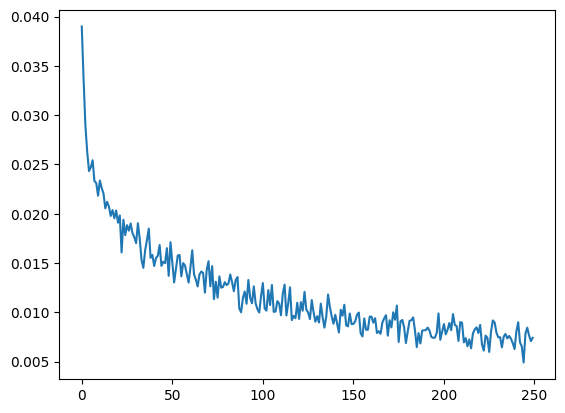

FOLD 2
___________________________
Accuracy for fold 2: 89.64%


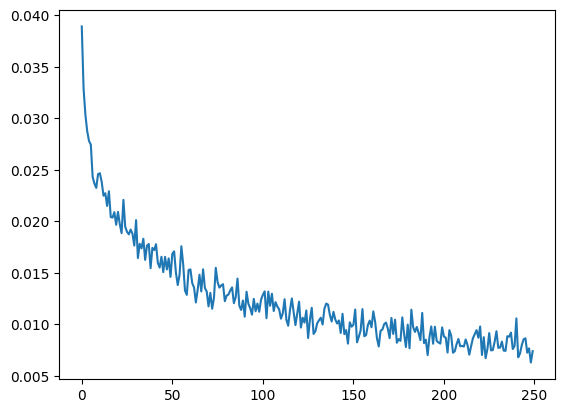

FOLD 3
___________________________
Accuracy for fold 3: 86.85%


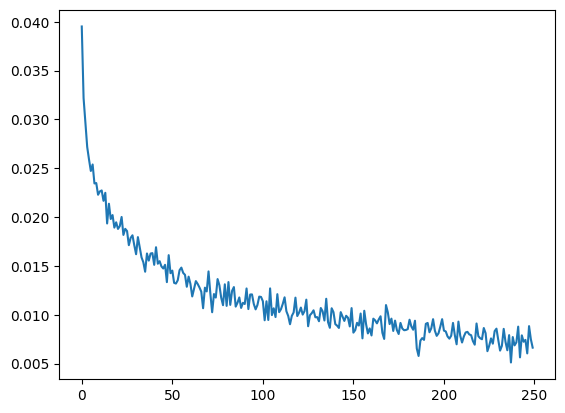

FOLD 4
___________________________
Accuracy for fold 4: 86.06%


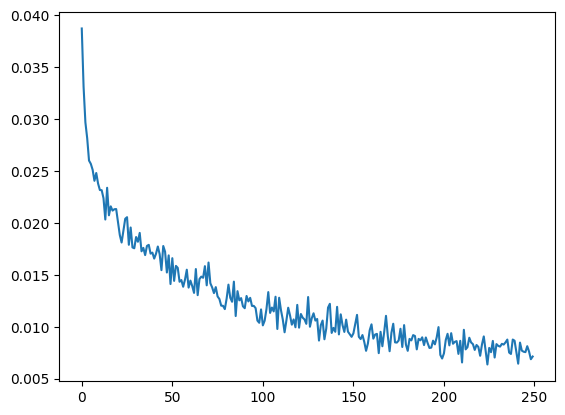

FOLD 5
___________________________
Accuracy for fold 5: 85.66%


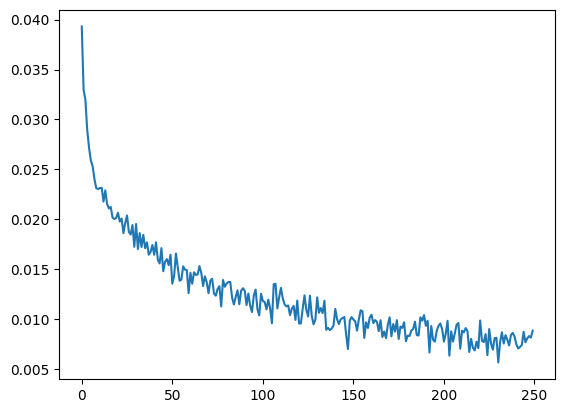

K-FOLD CV RESULTS FOR 5 FOLDS:
Average: 87.25%


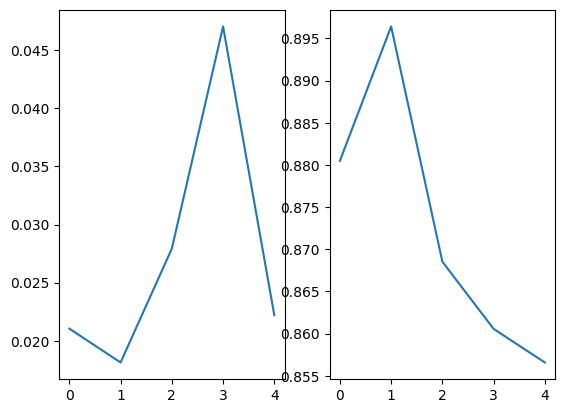

In [ ]:
################################################################
# Training process
################################################################
eval_loss = []
eval_accu = []
sum = 0.0

for fold, (train_ids, test_ids) in enumerate(kfold.split(np.arange(len(all_set)))):
  tran_loss = []
  print(f'FOLD {fold+1}')
  print('___________________________')

  # Create KFolds Dataloaders
  train_sampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_sampler = torch.utils.data.SubsetRandomSampler(test_ids)
  train_loader = torch.utils.data.DataLoader(all_set, batch_size=BATCH_SIZE, sampler=train_sampler)
  test_loader = torch.utils.data.DataLoader(all_set, batch_size=BATCH_SIZE, sampler=test_sampler)

  # Create/Reset model and optimzer for fold
  if torch.cuda.is_available():
    model = regMLPNet(data_shape).cuda()
  else:
    model = regMLPNet(data_shape)

  optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)

  for epoch in range(EPOCHS):
    epoch_loss = train_epoch(model, train_loader, criterion, optimizer)
    tran_loss.append(epoch_loss)

  val_loss, val_accu = valid_epoch(model, test_loader, criterion)
  eval_loss.append(val_loss)
  eval_accu.append(val_accu)

  key_name = f'{model.name()} Fold: {fold+1}'
  kRESULTS[key_name] = 100.0*val_accu
  print(f'Accuracy for fold {fold+1}: {kRESULTS[key_name]:.2f}%')
  modelPath = f'./{model.name()}_fold{fold+1}.pth'
  torch.save(model.state_dict(), modelPath)

  sum += val_accu

  plt.plot(tran_loss)
  plt.show()

fig, ax = plt.subplots(1,2)
ax[0].plot(eval_loss)
ax[1].plot(eval_accu)
print(f'K-FOLD CV RESULTS FOR {FOLDS} FOLDS:')

avgAccu = 100*sum/FOLDS
RESULTS[f'{model.name()} 5-Fold Avg with No Fit Features'] = avgAccu
print(f'Average: {avgAccu:.2f}%')

#### RNN

FOLD 1
___________________________
Accuracy for fold 1: 79.68%


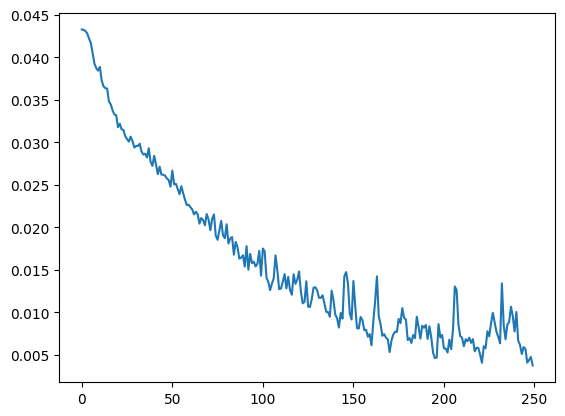

FOLD 2
___________________________
Accuracy for fold 2: 80.08%


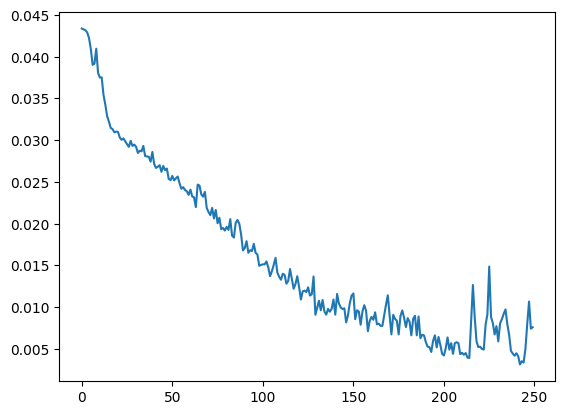

FOLD 3
___________________________
Accuracy for fold 3: 86.85%


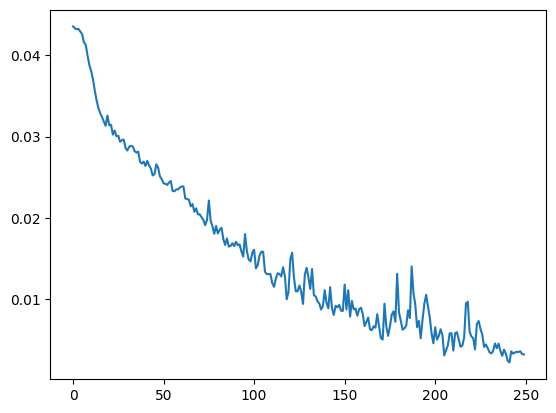

FOLD 4
___________________________
Accuracy for fold 4: 81.27%


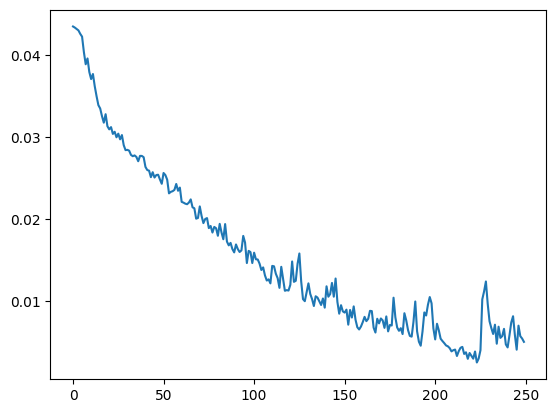

FOLD 5
___________________________
Accuracy for fold 5: 82.07%


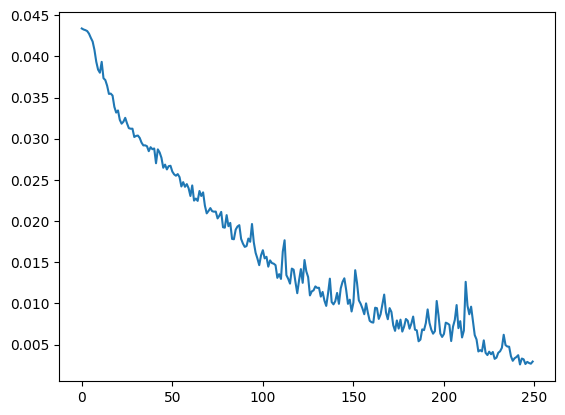

K-FOLD CV RESULTS FOR 5 FOLDS:
Average: 81.99%


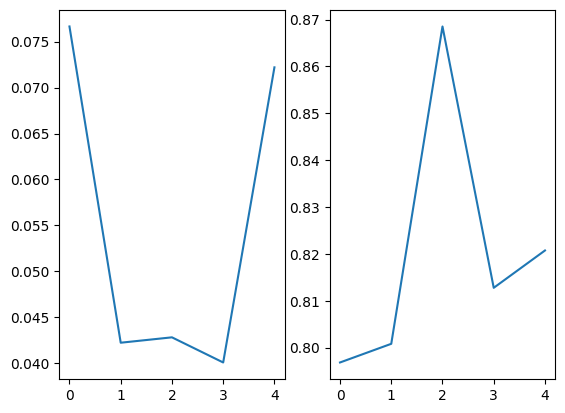

In [ ]:
################################################################
# Training process
################################################################
eval_loss = []
eval_accu = []
sum = 0.0

for fold, (train_ids, test_ids) in enumerate(kfold.split(np.arange(len(all_set)))):
  tran_loss = []
  print(f'FOLD {fold+1}')
  print('___________________________')

  # Create KFolds Dataloaders
  train_sampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_sampler = torch.utils.data.SubsetRandomSampler(test_ids)
  train_loader = torch.utils.data.DataLoader(all_set, batch_size=BATCH_SIZE, sampler=train_sampler)
  test_loader = torch.utils.data.DataLoader(all_set, batch_size=BATCH_SIZE, sampler=test_sampler)

  # Create/Reset model and optimzer for fold
  if torch.cuda.is_available():
    model = RNNet(data_shape[::-1]).cuda()
  else:
    model = RNNet(data_shape[::-1])

  optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)

  for epoch in range(EPOCHS):
    epoch_loss = train_epoch(model, train_loader, criterion, optimizer)
    tran_loss.append(epoch_loss)

  val_loss, val_accu = valid_epoch(model, test_loader, criterion)
  eval_loss.append(val_loss)
  eval_accu.append(val_accu)

  key_name = f'{model.name()} Fold: {fold+1}'
  kRESULTS[key_name] = 100.0*val_accu
  print(f'Accuracy for fold {fold+1}: {kRESULTS[key_name]:.2f}%')
  modelPath = f'./{model.name()}_fold{fold+1}.pth'
  torch.save(model.state_dict(), modelPath)

  sum += val_accu

  plt.plot(tran_loss)
  plt.show()

fig, ax = plt.subplots(1,2)
ax[0].plot(eval_loss)
ax[1].plot(eval_accu)
print(f'K-FOLD CV RESULTS FOR {FOLDS} FOLDS:')

avgAccu = 100*sum/FOLDS
RESULTS[f'{model.name()} 5-Fold Avg with No Fit Features'] = avgAccu
print(f'Average: {avgAccu:.2f}%')

## Results from all (to this point)

In [ ]:
for net, accu in RESULTS.items():
  print(f'Accuracy for {net}: {accu:.2f}%')

Accuracy for MLP: 80.16%
Accuracy for regMLP: 87.30%
Accuracy for RNN: 84.92%
Accuracy for MLP 5-Fold Avg: 85.66%
Accuracy for regMLP 5-Fold Avg: 89.72%
Accuracy for RNN 5-Fold Avg: 83.75%
Accuracy for MLP 5-Fold Avg with No Fit Features: 83.51%
Accuracy for regMLP 5-Fold Avg with No Fit Features: 87.25%
Accuracy for RNN 5-Fold Avg with No Fit Features: 81.99%


## Retesting 5-Fold CV with only 6 hyper-features and no augmentation
Excluding fit features from lifetime-based data

In [ ]:
################################################################
# Create and standardize/normalize dataset                     #
################################################################
################################################################
# Create and standardize/normalize dataset                     #
################################################################
modes = ['G', 'S', 'Photons', 'NADH', 'FAD', 'ORR']
times = ['0hpt-Baseline', '1hpt', '24hpt', '48hpt']
treatment = ['NT']
set_list = []
sen_set, res_set = {}, {}
keys =[]

for tx in treatment:
  for t in times:
    key = (tx + '_' + t)
    dir_ext = os.sep + tx + os.sep + t
    try:
      sen_set[key] = UMSCC_Dist_Dataset('Stacks/22B' + dir_ext, modes, bins=bins, augment=False)
      res_set[key] = UMSCC_Dist_Dataset('Stacks/47' + dir_ext, modes, bins=bins, augment=False)
      sen_set[key].normalize()
      res_set[key].normalize()
      set_list.append(sen_set[key])
      set_list.append(res_set[key])
      keys.append(key)
    except Exception as e:
      print(f'Skipping {key}: {e}')

all_set = ConcatDataset(set_list)
data_shape = np.shape(set_list[0].dists)[1:]

In [ ]:
################################################################
# Final datset splits and dataloader instantiation             #
# This will be overwritten if K-Fold CV is called in training  #
################################################################
BATCH_SIZE = 16
train_size = int(0.75 * len(all_set))
val_size = int(0.2 * train_size)
test_size = len(all_set) - (train_size + val_size)
train_set, val_set, test_set = torch.utils.data.random_split(
    dataset=all_set,
    lengths=[train_size, val_size, test_size])

train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=BATCH_SIZE,
    shuffle=True)
val_loader = torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=BATCH_SIZE,
    shuffle=False)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=BATCH_SIZE,
    shuffle=False)


In [ ]:
##############################
## Print lengths of subsets ##
##############################
print('Training set size: ', len(train_set))
print('Validation set size: ', len(val_set))
print('Testing set size: ', len(test_set))

Training set size:  188
Validation set size:  37
Testing set size:  26


### Training

#### Simple MLP

FOLD 1
___________________________
Accuracy for fold 1: 78.43%


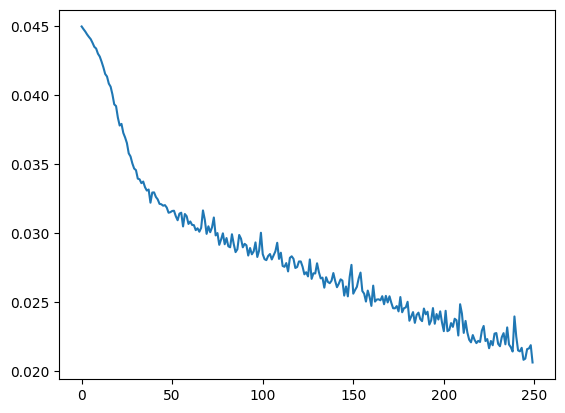

FOLD 2
___________________________
Accuracy for fold 2: 66.00%


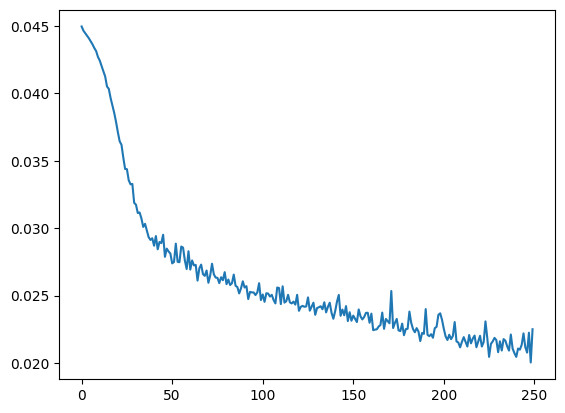

FOLD 3
___________________________
Accuracy for fold 3: 80.00%


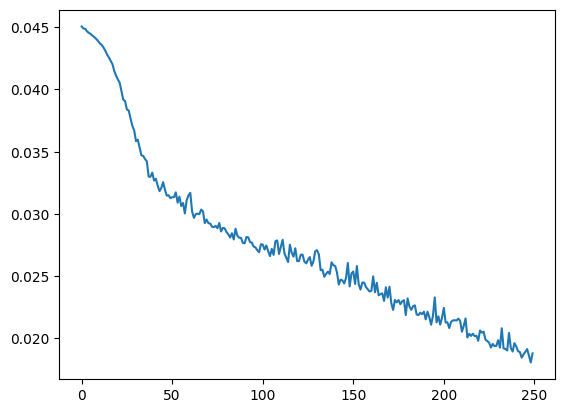

FOLD 4
___________________________
Accuracy for fold 4: 74.00%


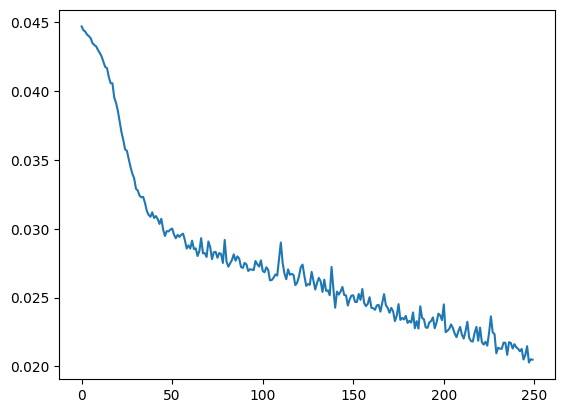

FOLD 5
___________________________
Accuracy for fold 5: 78.00%


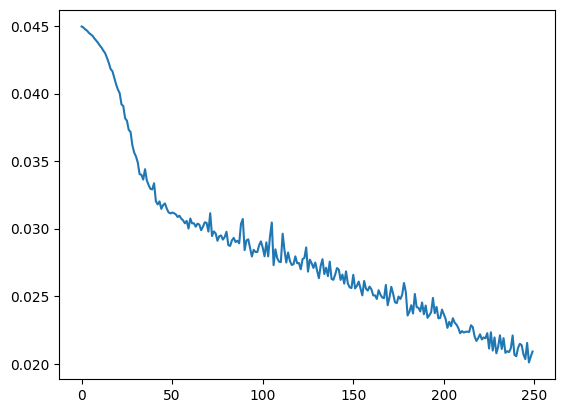

K-FOLD CV RESULTS FOR 5 FOLDS:
Average: 75.29%


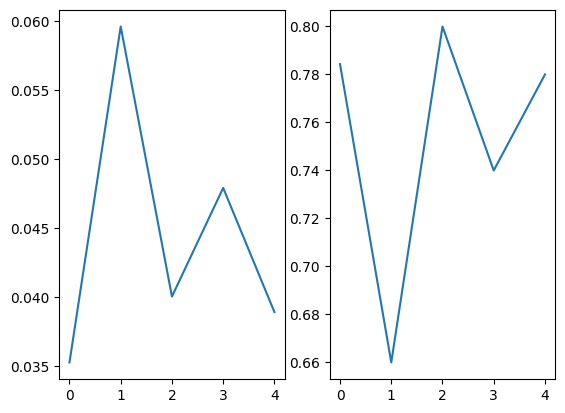

In [ ]:
################################################################
# Training process
################################################################
eval_loss = []
eval_accu = []
sum = 0.0

for fold, (train_ids, test_ids) in enumerate(kfold.split(np.arange(len(all_set)))):
  tran_loss = []
  print(f'FOLD {fold+1}')
  print('___________________________')

  # Create KFolds Dataloaders
  train_sampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_sampler = torch.utils.data.SubsetRandomSampler(test_ids)
  train_loader = torch.utils.data.DataLoader(all_set, batch_size=BATCH_SIZE, sampler=train_sampler)
  test_loader = torch.utils.data.DataLoader(all_set, batch_size=BATCH_SIZE, sampler=test_sampler)

  # Create/Reset model and optimzer for fold
  if torch.cuda.is_available():
    model = MLPNet(data_shape).cuda()
  else:
    model = MLPNet(data_shape)

  optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)

  for epoch in range(EPOCHS):
    epoch_loss = train_epoch(model, train_loader, criterion, optimizer)
    tran_loss.append(epoch_loss)

  val_loss, val_accu = valid_epoch(model, test_loader, criterion)
  eval_loss.append(val_loss)
  eval_accu.append(val_accu)

  key_name = f'{model.name()} Fold: {fold+1}'
  kRESULTS[key_name] = 100.0*val_accu
  print(f'Accuracy for fold {fold+1}: {kRESULTS[key_name]:.2f}%')
  modelPath = f'./{model.name()}_fold{fold+1}.pth'
  torch.save(model.state_dict(), modelPath)

  sum += val_accu

  plt.plot(tran_loss)
  plt.show()

fig, ax = plt.subplots(1,2)
ax[0].plot(eval_loss)
ax[1].plot(eval_accu)
print(f'K-FOLD CV RESULTS FOR {FOLDS} FOLDS:')

avgAccu = 100*sum/FOLDS
RESULTS[f'{model.name()} 5-Fold Avg with No Fit Features no Augmentation '] = avgAccu
print(f'Average: {avgAccu:.2f}%')

#### Regularized MLP

FOLD 1
___________________________
Accuracy for fold 1: 82.35%


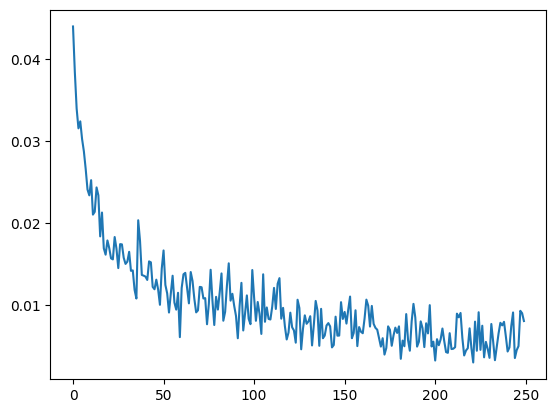

FOLD 2
___________________________
Accuracy for fold 2: 86.00%


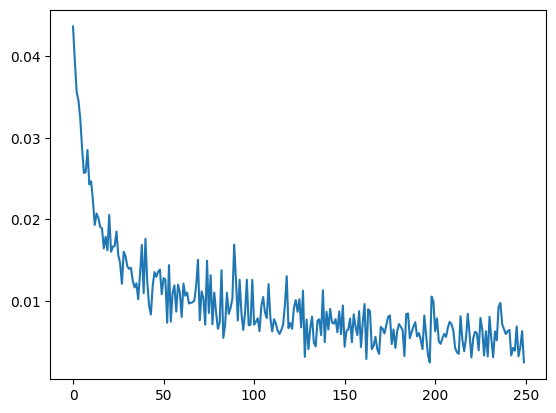

FOLD 3
___________________________
Accuracy for fold 3: 82.00%


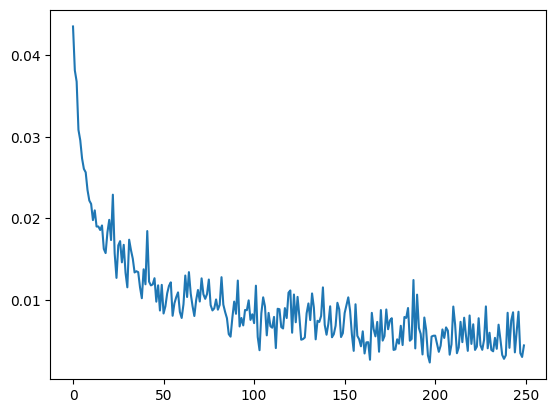

FOLD 4
___________________________
Accuracy for fold 4: 90.00%


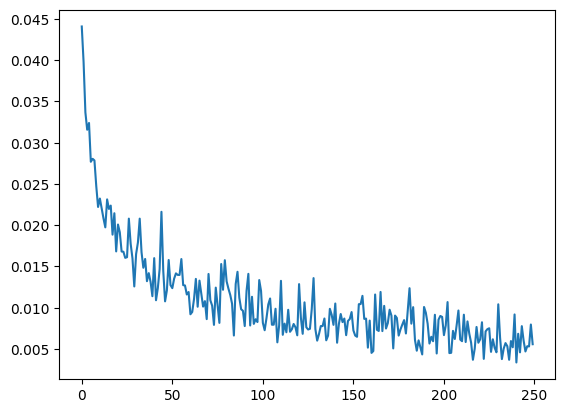

FOLD 5
___________________________
Accuracy for fold 5: 72.00%


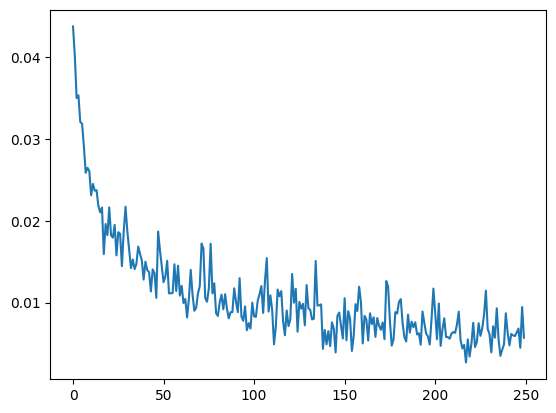

K-FOLD CV RESULTS FOR 5 FOLDS:
Average: 82.47%


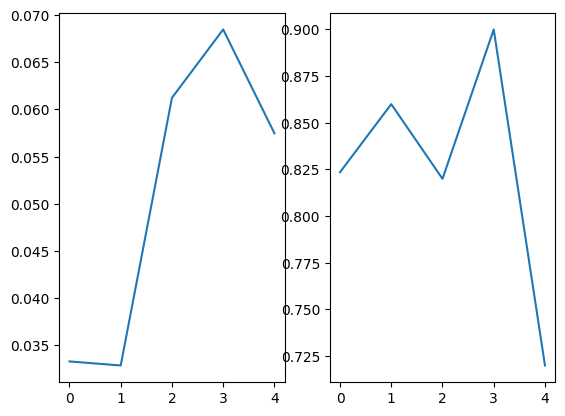

In [ ]:
################################################################
# Training process
################################################################
eval_loss = []
eval_accu = []
sum = 0.0

for fold, (train_ids, test_ids) in enumerate(kfold.split(np.arange(len(all_set)))):
  tran_loss = []
  print(f'FOLD {fold+1}')
  print('___________________________')

  # Create KFolds Dataloaders
  train_sampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_sampler = torch.utils.data.SubsetRandomSampler(test_ids)
  train_loader = torch.utils.data.DataLoader(all_set, batch_size=BATCH_SIZE, sampler=train_sampler)
  test_loader = torch.utils.data.DataLoader(all_set, batch_size=BATCH_SIZE, sampler=test_sampler)

  # Create/Reset model and optimzer for fold
  if torch.cuda.is_available():
    model = regMLPNet(data_shape).cuda()
  else:
    model = regMLPNet(data_shape)

  optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)

  for epoch in range(EPOCHS):
    epoch_loss = train_epoch(model, train_loader, criterion, optimizer)
    tran_loss.append(epoch_loss)

  val_loss, val_accu = valid_epoch(model, test_loader, criterion)
  eval_loss.append(val_loss)
  eval_accu.append(val_accu)

  key_name = f'{model.name()} Fold: {fold+1}'
  kRESULTS[key_name] = 100.0*val_accu
  print(f'Accuracy for fold {fold+1}: {kRESULTS[key_name]:.2f}%')
  modelPath = f'./{model.name()}_fold{fold+1}.pth'
  torch.save(model.state_dict(), modelPath)

  sum += val_accu

  plt.plot(tran_loss)
  plt.show()

fig, ax = plt.subplots(1,2)
ax[0].plot(eval_loss)
ax[1].plot(eval_accu)
print(f'K-FOLD CV RESULTS FOR {FOLDS} FOLDS:')

avgAccu = 100*sum/FOLDS
RESULTS[f'{model.name()} 5-Fold Avg with No Fit Features no Augmentation'] = avgAccu
print(f'Average: {avgAccu:.2f}%')

#### RNN

FOLD 1
___________________________
Accuracy for fold 1: 66.67%


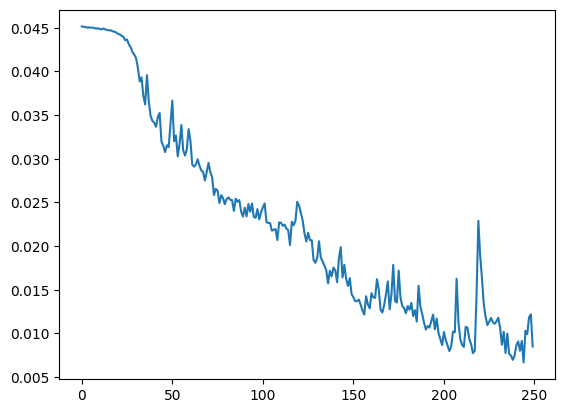

FOLD 2
___________________________
Accuracy for fold 2: 82.00%


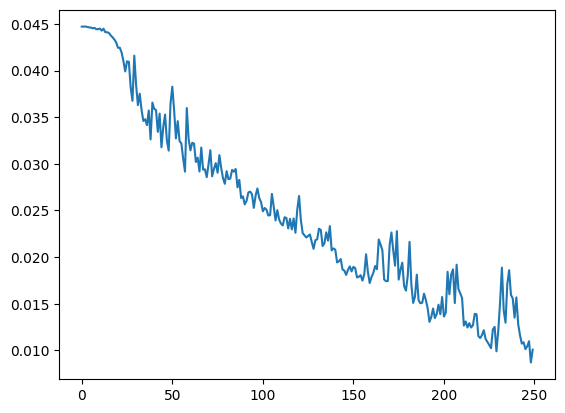

FOLD 3
___________________________
Accuracy for fold 3: 72.00%


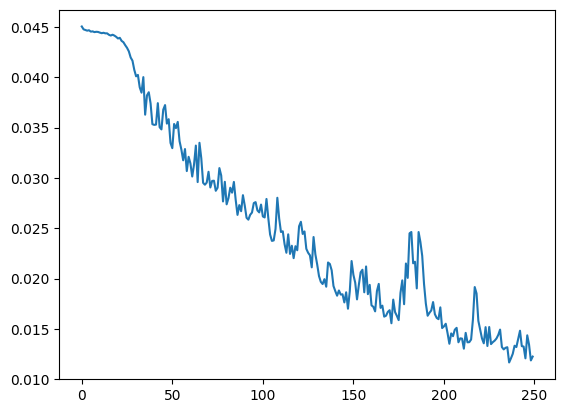

FOLD 4
___________________________
Accuracy for fold 4: 82.00%


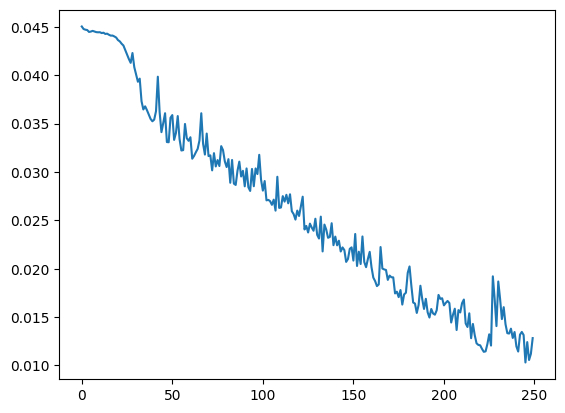

FOLD 5
___________________________
Accuracy for fold 5: 78.00%


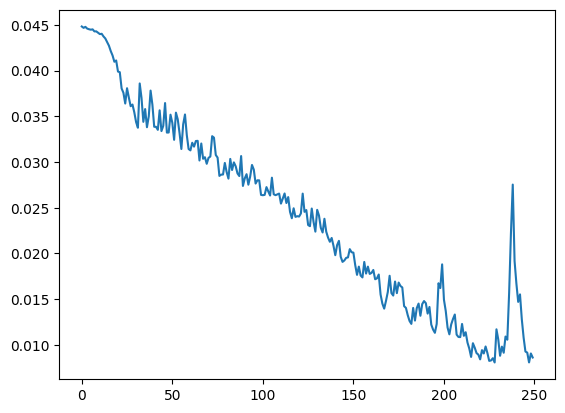

K-FOLD CV RESULTS FOR 5 FOLDS:
Average: 76.13%


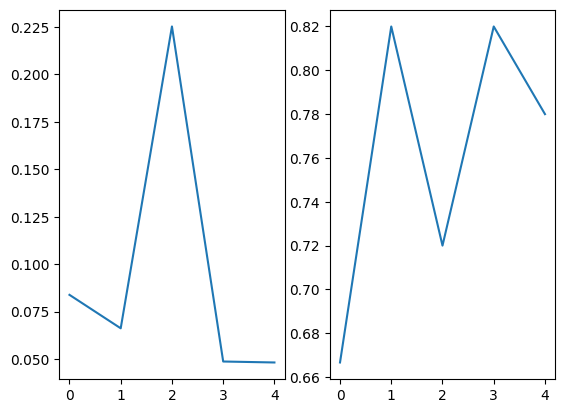

In [ ]:
################################################################
# Training process
################################################################
eval_loss = []
eval_accu = []
sum = 0.0

for fold, (train_ids, test_ids) in enumerate(kfold.split(np.arange(len(all_set)))):
  tran_loss = []
  print(f'FOLD {fold+1}')
  print('___________________________')

  # Create KFolds Dataloaders
  train_sampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_sampler = torch.utils.data.SubsetRandomSampler(test_ids)
  train_loader = torch.utils.data.DataLoader(all_set, batch_size=BATCH_SIZE, sampler=train_sampler)
  test_loader = torch.utils.data.DataLoader(all_set, batch_size=BATCH_SIZE, sampler=test_sampler)

  # Create/Reset model and optimzer for fold
  if torch.cuda.is_available():
    model = RNNet(data_shape[::-1]).cuda()
  else:
    model = RNNet(data_shape[::-1])

  optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)

  for epoch in range(EPOCHS):
    epoch_loss = train_epoch(model, train_loader, criterion, optimizer)
    tran_loss.append(epoch_loss)

  val_loss, val_accu = valid_epoch(model, test_loader, criterion)
  eval_loss.append(val_loss)
  eval_accu.append(val_accu)

  key_name = f'{model.name()} Fold: {fold+1}'
  kRESULTS[key_name] = 100.0*val_accu
  print(f'Accuracy for fold {fold+1}: {kRESULTS[key_name]:.2f}%')
  modelPath = f'./{model.name()}_fold{fold+1}.pth'
  torch.save(model.state_dict(), modelPath)

  sum += val_accu

  plt.plot(tran_loss)
  plt.show()

fig, ax = plt.subplots(1,2)
ax[0].plot(eval_loss)
ax[1].plot(eval_accu)
print(f'K-FOLD CV RESULTS FOR {FOLDS} FOLDS:')

avgAccu = 100*sum/FOLDS
RESULTS[f'{model.name()} 5-Fold Avg with No Fit Features no Augmentation'] = avgAccu
print(f'Average: {avgAccu:.2f}%')

## Results from all (to this point)

In [ ]:
for net, accu in RESULTS.items():
  print(f'Accuracy for {net}: {accu:.2f}%')

Accuracy for MLP: 80.16%
Accuracy for regMLP: 87.30%
Accuracy for RNN: 84.92%
Accuracy for MLP 5-Fold Avg: 85.66%
Accuracy for regMLP 5-Fold Avg: 89.72%
Accuracy for RNN 5-Fold Avg: 83.75%
Accuracy for MLP 5-Fold Avg with No Fit Features: 83.51%
Accuracy for regMLP 5-Fold Avg with No Fit Features: 87.25%
Accuracy for RNN 5-Fold Avg with No Fit Features: 81.99%
Accuracy for MLP 5-Fold Avg with No Fit Features no Augmentation : 75.29%
Accuracy for regMLP 5-Fold Avg with No Fit Features no Augmentation: 82.47%
Accuracy for RNN 5-Fold Avg with No Fit Features no Augmentation: 76.13%


In [ ]:
Hyperpar_Results = {}
Hyperpar_Results["High LR, Low Epochs"] = RESULTS

# Low LR and high epochs

## Single Model training & testing
Training each model once and comparing test results

## Setting up datasets for training

Using all controls dataset (for maximum size with minimal confouding variables)

In [ ]:
################################################################
# Create and standardize/normalize dataset                     #
################################################################
modes = ['all']
bins = 25

times = ['0hpt-Baseline', '1hpt', '24hpt', '48hpt']
treatment = ['NT']
set_list = []
sen_set, res_set = {}, {}
keys =[]

for tx in treatment:
  for t in times:
    key = (tx + '_' + t)
    dir_ext = os.sep + tx + os.sep + t
    try:
      sen_set[key] = UMSCC_Dist_Dataset('Stacks/22B' + dir_ext, modes, bins=bins, augment=True)
      res_set[key] = UMSCC_Dist_Dataset('Stacks/47' + dir_ext, modes, bins=bins, augment=True)
      sen_set[key].normalize()
      res_set[key].normalize()
      set_list.append(sen_set[key])
      set_list.append(res_set[key])
      keys.append(key)
    except Exception as e:
      print(f'Skipping {key}: {e}')

all_set = ConcatDataset(set_list)
data_shape = np.shape(set_list[0].dists)[1:]

In [ ]:
################################################################
# Final datset splits and dataloader instantiation             #
# This will be overwritten if K-Fold CV is called in training  #
################################################################
BATCH_SIZE = 16
train_size = int(0.75 * len(all_set))
val_size = int(0.2 * train_size)
test_size = len(all_set) - (train_size + val_size)
train_set, val_set, test_set = torch.utils.data.random_split(
    dataset=all_set,
    lengths=[train_size, val_size, test_size])

train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=BATCH_SIZE,
    shuffle=True)
val_loader = torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=BATCH_SIZE,
    shuffle=False)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=BATCH_SIZE,
    shuffle=False)

In [ ]:
##############################
## Print lengths of subsets ##
##############################
print('Training set size: ', len(train_set))
print('Validation set size: ', len(val_set))
print('Testing set size: ', len(test_set))

### Training

In [ ]:
################################################################
# Hyper parameters                                            #
################################################################
LR = 0.0001 # learning rate
EPOCHS = 500 # number of epochs to train model
RESULTS = {}

#### Simple MLP Net
Flatten data into vector, one hidden layer with size=100, ReLU nonlinearity, and sigmoidactivation at final output.

In [ ]:
################################################################
# Create model
################################################################
if torch.cuda.is_available():
  model = MLPNet(data_shape).cuda()
else:
  model = MLPNet(data_shape)

modelPath = f'./{model.name()}.pth'
print(summary(model, input_size=(BATCH_SIZE,) + data_shape))

################################################################
# Create optimizer and criterion
################################################################
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)
criterion = nn.BCELoss()

In [ ]:
tran_loss = []
eval_accu = []
eval_loss = []

for epoch in range(EPOCHS):
  epoch_loss = train_epoch(model, train_loader, criterion, optimizer)
  tran_loss.append(epoch_loss)

  val_loss, val_accu  = valid_epoch(model, val_loader, criterion)
  eval_loss.append(val_loss)
  eval_accu.append(val_accu)

  print(f'==>>> epoch: {epoch}, train loss: {tran_loss[-1]:.6f}, val loss: {eval_loss[-1]:.6f}, val accuracy: {eval_accu[-1]:.6f}')

  if epoch == 0:
    best_acc = eval_accu[-1]
    torch.save(model.state_dict(), modelPath)
  elif eval_accu[-1] > best_acc:
    torch.save(model.state_dict(), modelPath)
    best_acc = eval_accu[-1]

fig, ax = plt.subplots(1, 2)
ax[0].plot(tran_loss)
ax[0].plot(eval_loss)
ax[1].plot(eval_accu)

In [ ]:
################################################################
# Testing process
################################################################
model = MLPNet(data_shape)
modelPath = './' + model.name() + '.pth'
model.load_state_dict(torch.load(modelPath))

correct = 0
with torch.no_grad():
  model.eval()
  for batch_idx, (x, target) in enumerate(test_loader):
    if torch.cuda.is_available():
      x, target = x.cuda(), target.cuda()
    out = model(x)
    pred_label = torch.round(out)
    grou_truth = target.unsqueeze(-1)
    correct += (pred_label == grou_truth).sum().item()

accu = 100*correct/len(test_set)
RESULTS[model.name()] = accu

#### Regualrized MLP
Batch norm on input and dropouts at hiddne layer.



In [ ]:
################################################################
# Create model
################################################################
if torch.cuda.is_available():
  model = regMLPNet(data_shape).cuda()
else:
  model = regMLPNet(data_shape)

modelPath = f'./{model.name()}.pth'
print(summary(model, input_size=(BATCH_SIZE,) + data_shape))

################################################################
# Create optimizer and criterion
################################################################
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)
criterion = nn.BCELoss()

In [ ]:
tran_loss = []
eval_accu = []
eval_loss = []

for epoch in range(EPOCHS):
  epoch_loss = train_epoch(model, train_loader, criterion, optimizer)
  tran_loss.append(epoch_loss)

  val_loss, val_accu  = valid_epoch(model, val_loader, criterion)
  eval_loss.append(val_loss)
  eval_accu.append(val_accu)

  print(f'==>>> epoch: {epoch}, train loss: {tran_loss[-1]:.6f}, val loss: {eval_loss[-1]:.6f}, val accuracy: {eval_accu[-1]:.6f}')

  if epoch == 0:
    best_acc = eval_accu[-1]
    torch.save(model.state_dict(), modelPath)
  elif eval_accu[-1] > best_acc:
    torch.save(model.state_dict(), modelPath)
    best_acc = eval_accu[-1]

fig, ax = plt.subplots(1, 2)
ax[0].plot(tran_loss)
ax[0].plot(eval_loss)
ax[1].plot(eval_accu)

In [ ]:
################################################################
# Testing process
################################################################
model = regMLPNet(data_shape)
modelPath = './' + model.name() + '.pth'
model.load_state_dict(torch.load(modelPath))

total_loss = 0
correct = 0
with torch.no_grad():
  model.eval()
  for batch_idx, (x, target) in enumerate(test_loader):
    if torch.cuda.is_available():
      x, target = x.cuda(), target.cuda()
    out = model(x)
    pred_label = torch.round(out)
    grou_truth = target.unsqueeze(-1)
    correct += (pred_label == grou_truth).sum().item()

accu = 100*correct/len(test_set)
RESULTS[model.name()] = accu

#### RNN

In [ ]:
################################################################
# Create model
################################################################
if torch.cuda.is_available():
  model = RNNet(data_shape[::-1]).cuda()
else:
  model = RNNet(data_shape[::-1])

modelPath = f'./{model.name()}.pth'
print(summary(model, input_size=(BATCH_SIZE,) + data_shape))

################################################################
# Create optimizer and criterion
################################################################
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)
criterion = nn.BCELoss()

In [ ]:
tran_loss = []
eval_accu = []
eval_loss = []

for epoch in range(EPOCHS):
  epoch_loss = train_epoch(model, train_loader, criterion, optimizer)
  tran_loss.append(epoch_loss)

  val_loss, val_accu  = valid_epoch(model, val_loader, criterion)
  eval_loss.append(val_loss)
  eval_accu.append(val_accu)

  print(f'==>>> epoch: {epoch}, train loss: {tran_loss[-1]:.6f}, val loss: {eval_loss[-1]:.6f}, val accuracy: {eval_accu[-1]:.6f}')

  if epoch == 0:
    best_acc = eval_accu[-1]
    torch.save(model.state_dict(), modelPath)
  elif eval_accu[-1] > best_acc:
    torch.save(model.state_dict(), modelPath)
    best_acc = eval_accu[-1]

fig, ax = plt.subplots(1, 2)
ax[0].plot(tran_loss)
ax[0].plot(eval_loss)
ax[1].plot(eval_accu)

In [ ]:
################################################################
# Testing process
################################################################
model = RNNet(data_shape[::-1])
modelPath = './' + model.name() + '.pth'
model.load_state_dict(torch.load(modelPath))

total_loss = 0
correct = 0
with torch.no_grad():
  model.eval()
  for batch_idx, (x, target) in enumerate(test_loader):
    if torch.cuda.is_available():
      x, target = x.cuda(), target.cuda()
    out = model(x)
    pred_label = torch.round(out)
    grou_truth = target.unsqueeze(-1)
    correct += (pred_label == grou_truth).sum().item()

accu = 100*correct/len(test_set)
RESULTS[model.name()] = accu

### Results
With train, eval loop, svaing most accurate model in evaluation and testing on unseen dataset.

In [ ]:
for net in RESULTS:
  print(f'Accuracy for {net}: {RESULTS[net]:.2f}%')

## 5-Fold Cross Validation Model Training & Testing
With train loop on fresh model and testing each fold on unseen dataset. Saving at each fold and colelcting average results across models.

In [ ]:
FOLDS = 5
kfold = KFold(n_splits = FOLDS, shuffle = True)
kRESULTS = {}

### Training

#### Simple MLP

In [ ]:
################################################################
# Training process
################################################################
eval_loss = []
eval_accu = []
sum = 0.0

for fold, (train_ids, test_ids) in enumerate(kfold.split(np.arange(len(all_set)))):
  tran_loss = []
  print(f'FOLD {fold+1}')
  print('___________________________')

  # Create KFolds Dataloaders
  train_sampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_sampler = torch.utils.data.SubsetRandomSampler(test_ids)
  train_loader = torch.utils.data.DataLoader(all_set, batch_size=BATCH_SIZE, sampler=train_sampler)
  test_loader = torch.utils.data.DataLoader(all_set, batch_size=BATCH_SIZE, sampler=test_sampler)

  # Create/Reset model and optimzer for fold
  if torch.cuda.is_available():
    model = MLPNet(data_shape).cuda()
  else:
    model = MLPNet(data_shape)

  optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)

  for epoch in range(EPOCHS):
    epoch_loss = train_epoch(model, train_loader, criterion, optimizer)
    tran_loss.append(epoch_loss)

  val_loss, val_accu = valid_epoch(model, test_loader, criterion)
  eval_loss.append(val_loss)
  eval_accu.append(val_accu)

  key_name = f'{model.name()} Fold: {fold+1}'
  kRESULTS[key_name] = 100.0*val_accu
  print(f'Accuracy for fold {fold+1}: {kRESULTS[key_name]:.2f}%')
  modelPath = f'./{model.name()}_fold{fold+1}.pth'
  torch.save(model.state_dict(), modelPath)

  sum += val_accu

  plt.plot(tran_loss)
  plt.show()

fig, ax = plt.subplots(1,2)
ax[0].plot(eval_loss)
ax[1].plot(eval_accu)
print(f'K-FOLD CV RESULTS FOR {FOLDS} FOLDS:')

avgAccu = 100*sum/FOLDS
RESULTS[f'{model.name()} 5-Fold Avg'] = avgAccu
print(f'Average: {avgAccu:.2f}%')

#### Regularized MLP

In [ ]:
################################################################
# Training process
################################################################
eval_loss = []
eval_accu = []
sum = 0.0

for fold, (train_ids, test_ids) in enumerate(kfold.split(np.arange(len(all_set)))):
  tran_loss = []
  print(f'FOLD {fold+1}')
  print('___________________________')

  # Create KFolds Dataloaders
  train_sampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_sampler = torch.utils.data.SubsetRandomSampler(test_ids)
  train_loader = torch.utils.data.DataLoader(all_set, batch_size=BATCH_SIZE, sampler=train_sampler)
  test_loader = torch.utils.data.DataLoader(all_set, batch_size=BATCH_SIZE, sampler=test_sampler)

  # Create/Reset model and optimzer for fold
  if torch.cuda.is_available():
    model = regMLPNet(data_shape).cuda()
  else:
    model = regMLPNet(data_shape)

  optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)

  for epoch in range(EPOCHS):
    epoch_loss = train_epoch(model, train_loader, criterion, optimizer)
    tran_loss.append(epoch_loss)

  val_loss, val_accu = valid_epoch(model, test_loader, criterion)
  eval_loss.append(val_loss)
  eval_accu.append(val_accu)

  key_name = f'{model.name()} Fold: {fold+1}'
  kRESULTS[key_name] = 100.0*val_accu
  print(f'Accuracy for fold {fold+1}: {kRESULTS[key_name]:.2f}%')
  modelPath = f'./{model.name()}_fold{fold+1}.pth'
  torch.save(model.state_dict(), modelPath)

  sum += val_accu

  plt.plot(tran_loss)
  plt.show()

fig, ax = plt.subplots(1,2)
ax[0].plot(eval_loss)
ax[1].plot(eval_accu)
print(f'K-FOLD CV RESULTS FOR {FOLDS} FOLDS:')

avgAccu = 100*sum/FOLDS
RESULTS[f'{model.name()} 5-Fold Avg'] = avgAccu
print(f'Average: {avgAccu:.2f}%')

#### RNN

In [ ]:
################################################################
# Training process
################################################################
eval_loss = []
eval_accu = []
sum = 0.0

for fold, (train_ids, test_ids) in enumerate(kfold.split(np.arange(len(all_set)))):
  tran_loss = []
  print(f'FOLD {fold+1}')
  print('___________________________')

  # Create KFolds Dataloaders
  train_sampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_sampler = torch.utils.data.SubsetRandomSampler(test_ids)
  train_loader = torch.utils.data.DataLoader(all_set, batch_size=BATCH_SIZE, sampler=train_sampler)
  test_loader = torch.utils.data.DataLoader(all_set, batch_size=BATCH_SIZE, sampler=test_sampler)

  # Create/Reset model and optimzer for fold
  if torch.cuda.is_available():
    model = RNNet(data_shape[::-1]).cuda()
  else:
    model = RNNet(data_shape[::-1])

  optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)

  for epoch in range(EPOCHS):
    epoch_loss = train_epoch(model, train_loader, criterion, optimizer)
    tran_loss.append(epoch_loss)

  val_loss, val_accu = valid_epoch(model, test_loader, criterion)
  eval_loss.append(val_loss)
  eval_accu.append(val_accu)

  key_name = f'{model.name()} Fold: {fold+1}'
  kRESULTS[key_name] = 100.0*val_accu
  print(f'Accuracy for fold {fold+1}: {kRESULTS[key_name]:.2f}%')
  modelPath = f'./{model.name()}_fold{fold+1}.pth'
  torch.save(model.state_dict(), modelPath)

  sum += val_accu

  plt.plot(tran_loss)
  plt.show()

fig, ax = plt.subplots(1,2)
ax[0].plot(eval_loss)
ax[1].plot(eval_accu)
print(f'K-FOLD CV RESULTS FOR {FOLDS} FOLDS:')

avgAccu = 100*sum/FOLDS
RESULTS[f'{model.name()} 5-Fold Avg'] = avgAccu
print(f'Average: {avgAccu:.2f}%')

## Results from both training styles

In [ ]:
for net, accu in RESULTS.items():
  print(f'Accuracy for {net}: {accu:.2f}%')

## Retesting 5-Fold CV with only 6 hyper-features
Excluding fit features from lifetime-based data

In [ ]:
################################################################
# Create and standardize/normalize dataset                     #
################################################################
modes = ['G', 'S', 'Photons', 'NADH', 'FAD', 'ORR']
times = ['0hpt-Baseline', '1hpt', '24hpt', '48hpt']
treatment = ['NT']
set_list = []
sen_set, res_set = {}, {}
keys =[]

for tx in treatment:
  for t in times:
    key = (tx + '_' + t)
    dir_ext = os.sep + tx + os.sep + t
    try:
      sen_set[key] = UMSCC_Dist_Dataset('Stacks/22B' + dir_ext, modes, bins=bins, augment=True)
      res_set[key] = UMSCC_Dist_Dataset('Stacks/47' + dir_ext, modes, bins=bins, augment=True)
      sen_set[key].normalize()
      res_set[key].normalize()
      set_list.append(sen_set[key])
      set_list.append(res_set[key])
      keys.append(key)
    except Exception as e:
      print(f'Skipping {key}: {e}')

all_set = ConcatDataset(set_list)
data_shape = np.shape(set_list[0].dists)[1:]

In [ ]:
################################################################
# Final datset splits and dataloader instantiation             #
# This will be overwritten if K-Fold CV is called in training  #
################################################################
BATCH_SIZE = 16
train_size = int(0.75 * len(all_set))
val_size = int(0.2 * train_size)
test_size = len(all_set) - (train_size + val_size)
train_set, val_set, test_set = torch.utils.data.random_split(
    dataset=all_set,
    lengths=[train_size, val_size, test_size])

train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=BATCH_SIZE,
    shuffle=True)
val_loader = torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=BATCH_SIZE,
    shuffle=False)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=BATCH_SIZE,
    shuffle=False)


### Training

#### Simple MLP

In [ ]:
################################################################
# Training process
################################################################
eval_loss = []
eval_accu = []
sum = 0.0

for fold, (train_ids, test_ids) in enumerate(kfold.split(np.arange(len(all_set)))):
  tran_loss = []
  print(f'FOLD {fold+1}')
  print('___________________________')

  # Create KFolds Dataloaders
  train_sampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_sampler = torch.utils.data.SubsetRandomSampler(test_ids)
  train_loader = torch.utils.data.DataLoader(all_set, batch_size=BATCH_SIZE, sampler=train_sampler)
  test_loader = torch.utils.data.DataLoader(all_set, batch_size=BATCH_SIZE, sampler=test_sampler)

  # Create/Reset model and optimzer for fold
  if torch.cuda.is_available():
    model = MLPNet(data_shape).cuda()
  else:
    model = MLPNet(data_shape)

  optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)

  for epoch in range(EPOCHS):
    epoch_loss = train_epoch(model, train_loader, criterion, optimizer)
    tran_loss.append(epoch_loss)

  val_loss, val_accu = valid_epoch(model, test_loader, criterion)
  eval_loss.append(val_loss)
  eval_accu.append(val_accu)

  key_name = f'{model.name()} Fold: {fold+1}'
  kRESULTS[key_name] = 100.0*val_accu
  print(f'Accuracy for fold {fold+1}: {kRESULTS[key_name]:.2f}%')
  modelPath = f'./{model.name()}_fold{fold+1}.pth'
  torch.save(model.state_dict(), modelPath)

  sum += val_accu

  plt.plot(tran_loss)
  plt.show()

fig, ax = plt.subplots(1,2)
ax[0].plot(eval_loss)
ax[1].plot(eval_accu)
print(f'K-FOLD CV RESULTS FOR {FOLDS} FOLDS:')

avgAccu = 100*sum/FOLDS
RESULTS[f'{model.name()} 5-Fold Avg with No Fit Features'] = avgAccu
print(f'Average: {avgAccu:.2f}%')

#### Regularized MLP

In [ ]:
################################################################
# Training process
################################################################
eval_loss = []
eval_accu = []
sum = 0.0

for fold, (train_ids, test_ids) in enumerate(kfold.split(np.arange(len(all_set)))):
  tran_loss = []
  print(f'FOLD {fold+1}')
  print('___________________________')

  # Create KFolds Dataloaders
  train_sampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_sampler = torch.utils.data.SubsetRandomSampler(test_ids)
  train_loader = torch.utils.data.DataLoader(all_set, batch_size=BATCH_SIZE, sampler=train_sampler)
  test_loader = torch.utils.data.DataLoader(all_set, batch_size=BATCH_SIZE, sampler=test_sampler)

  # Create/Reset model and optimzer for fold
  if torch.cuda.is_available():
    model = regMLPNet(data_shape).cuda()
  else:
    model = regMLPNet(data_shape)

  optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)

  for epoch in range(EPOCHS):
    epoch_loss = train_epoch(model, train_loader, criterion, optimizer)
    tran_loss.append(epoch_loss)

  val_loss, val_accu = valid_epoch(model, test_loader, criterion)
  eval_loss.append(val_loss)
  eval_accu.append(val_accu)

  key_name = f'{model.name()} Fold: {fold+1}'
  kRESULTS[key_name] = 100.0*val_accu
  print(f'Accuracy for fold {fold+1}: {kRESULTS[key_name]:.2f}%')
  modelPath = f'./{model.name()}_fold{fold+1}.pth'
  torch.save(model.state_dict(), modelPath)

  sum += val_accu

  plt.plot(tran_loss)
  plt.show()

fig, ax = plt.subplots(1,2)
ax[0].plot(eval_loss)
ax[1].plot(eval_accu)
print(f'K-FOLD CV RESULTS FOR {FOLDS} FOLDS:')

avgAccu = 100*sum/FOLDS
RESULTS[f'{model.name()} 5-Fold Avg with No Fit Features'] = avgAccu
print(f'Average: {avgAccu:.2f}%')

#### RNN

In [ ]:
################################################################
# Training process
################################################################
eval_loss = []
eval_accu = []
sum = 0.0

for fold, (train_ids, test_ids) in enumerate(kfold.split(np.arange(len(all_set)))):
  tran_loss = []
  print(f'FOLD {fold+1}')
  print('___________________________')

  # Create KFolds Dataloaders
  train_sampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_sampler = torch.utils.data.SubsetRandomSampler(test_ids)
  train_loader = torch.utils.data.DataLoader(all_set, batch_size=BATCH_SIZE, sampler=train_sampler)
  test_loader = torch.utils.data.DataLoader(all_set, batch_size=BATCH_SIZE, sampler=test_sampler)

  # Create/Reset model and optimzer for fold
  if torch.cuda.is_available():
    model = RNNet(data_shape[::-1]).cuda()
  else:
    model = RNNet(data_shape[::-1])

  optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)

  for epoch in range(EPOCHS):
    epoch_loss = train_epoch(model, train_loader, criterion, optimizer)
    tran_loss.append(epoch_loss)

  val_loss, val_accu = valid_epoch(model, test_loader, criterion)
  eval_loss.append(val_loss)
  eval_accu.append(val_accu)

  key_name = f'{model.name()} Fold: {fold+1}'
  kRESULTS[key_name] = 100.0*val_accu
  print(f'Accuracy for fold {fold+1}: {kRESULTS[key_name]:.2f}%')
  modelPath = f'./{model.name()}_fold{fold+1}.pth'
  torch.save(model.state_dict(), modelPath)

  sum += val_accu

  plt.plot(tran_loss)
  plt.show()

fig, ax = plt.subplots(1,2)
ax[0].plot(eval_loss)
ax[1].plot(eval_accu)
print(f'K-FOLD CV RESULTS FOR {FOLDS} FOLDS:')

avgAccu = 100*sum/FOLDS
RESULTS[f'{model.name()} 5-Fold Avg with No Fit Features'] = avgAccu
print(f'Average: {avgAccu:.2f}%')

## Results from all (to this point)

In [ ]:
for net, accu in RESULTS.items():
  print(f'Accuracy for {net}: {accu:.2f}%')

## Retesting 5-Fold CV with only 6 hyper-features and no augmentation
Excluding fit features from lifetime-based data

In [ ]:
################################################################
# Create and standardize/normalize dataset                     #
################################################################
################################################################
# Create and standardize/normalize dataset                     #
################################################################
modes = ['G', 'S', 'Photons', 'NADH', 'FAD', 'ORR']
times = ['0hpt-Baseline', '1hpt', '24hpt', '48hpt']
treatment = ['NT']
set_list = []
sen_set, res_set = {}, {}
keys =[]

for tx in treatment:
  for t in times:
    key = (tx + '_' + t)
    dir_ext = os.sep + tx + os.sep + t
    try:
      sen_set[key] = UMSCC_Dist_Dataset('Stacks/22B' + dir_ext, modes, bins=bins, augment=False)
      res_set[key] = UMSCC_Dist_Dataset('Stacks/47' + dir_ext, modes, bins=bins, augment=False)
      sen_set[key].normalize()
      res_set[key].normalize()
      set_list.append(sen_set[key])
      set_list.append(res_set[key])
      keys.append(key)
    except Exception as e:
      print(f'Skipping {key}: {e}')

all_set = ConcatDataset(set_list)
data_shape = np.shape(set_list[0].dists)[1:]

In [ ]:
################################################################
# Final datset splits and dataloader instantiation             #
# This will be overwritten if K-Fold CV is called in training  #
################################################################
BATCH_SIZE = 16
train_size = int(0.75 * len(all_set))
val_size = int(0.2 * train_size)
test_size = len(all_set) - (train_size + val_size)
train_set, val_set, test_set = torch.utils.data.random_split(
    dataset=all_set,
    lengths=[train_size, val_size, test_size])

train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=BATCH_SIZE,
    shuffle=True)
val_loader = torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=BATCH_SIZE,
    shuffle=False)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=BATCH_SIZE,
    shuffle=False)


In [ ]:
##############################
## Print lengths of subsets ##
##############################
print('Training set size: ', len(train_set))
print('Validation set size: ', len(val_set))
print('Testing set size: ', len(test_set))

### Training

#### Simple MLP

In [ ]:
################################################################
# Training process
################################################################
eval_loss = []
eval_accu = []
sum = 0.0

for fold, (train_ids, test_ids) in enumerate(kfold.split(np.arange(len(all_set)))):
  tran_loss = []
  print(f'FOLD {fold+1}')
  print('___________________________')

  # Create KFolds Dataloaders
  train_sampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_sampler = torch.utils.data.SubsetRandomSampler(test_ids)
  train_loader = torch.utils.data.DataLoader(all_set, batch_size=BATCH_SIZE, sampler=train_sampler)
  test_loader = torch.utils.data.DataLoader(all_set, batch_size=BATCH_SIZE, sampler=test_sampler)

  # Create/Reset model and optimzer for fold
  if torch.cuda.is_available():
    model = MLPNet(data_shape).cuda()
  else:
    model = MLPNet(data_shape)

  optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)

  for epoch in range(EPOCHS):
    epoch_loss = train_epoch(model, train_loader, criterion, optimizer)
    tran_loss.append(epoch_loss)

  val_loss, val_accu = valid_epoch(model, test_loader, criterion)
  eval_loss.append(val_loss)
  eval_accu.append(val_accu)

  key_name = f'{model.name()} Fold: {fold+1}'
  kRESULTS[key_name] = 100.0*val_accu
  print(f'Accuracy for fold {fold+1}: {kRESULTS[key_name]:.2f}%')
  modelPath = f'./{model.name()}_fold{fold+1}.pth'
  torch.save(model.state_dict(), modelPath)

  sum += val_accu

  plt.plot(tran_loss)
  plt.show()

fig, ax = plt.subplots(1,2)
ax[0].plot(eval_loss)
ax[1].plot(eval_accu)
print(f'K-FOLD CV RESULTS FOR {FOLDS} FOLDS:')

avgAccu = 100*sum/FOLDS
RESULTS[f'{model.name()} 5-Fold Avg with No Fit Features no Augmentation '] = avgAccu
print(f'Average: {avgAccu:.2f}%')

#### Regularized MLP

In [ ]:
################################################################
# Training process
################################################################
eval_loss = []
eval_accu = []
sum = 0.0

for fold, (train_ids, test_ids) in enumerate(kfold.split(np.arange(len(all_set)))):
  tran_loss = []
  print(f'FOLD {fold+1}')
  print('___________________________')

  # Create KFolds Dataloaders
  train_sampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_sampler = torch.utils.data.SubsetRandomSampler(test_ids)
  train_loader = torch.utils.data.DataLoader(all_set, batch_size=BATCH_SIZE, sampler=train_sampler)
  test_loader = torch.utils.data.DataLoader(all_set, batch_size=BATCH_SIZE, sampler=test_sampler)

  # Create/Reset model and optimzer for fold
  if torch.cuda.is_available():
    model = regMLPNet(data_shape).cuda()
  else:
    model = regMLPNet(data_shape)

  optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)

  for epoch in range(EPOCHS):
    epoch_loss = train_epoch(model, train_loader, criterion, optimizer)
    tran_loss.append(epoch_loss)

  val_loss, val_accu = valid_epoch(model, test_loader, criterion)
  eval_loss.append(val_loss)
  eval_accu.append(val_accu)

  key_name = f'{model.name()} Fold: {fold+1}'
  kRESULTS[key_name] = 100.0*val_accu
  print(f'Accuracy for fold {fold+1}: {kRESULTS[key_name]:.2f}%')
  modelPath = f'./{model.name()}_fold{fold+1}.pth'
  torch.save(model.state_dict(), modelPath)

  sum += val_accu

  plt.plot(tran_loss)
  plt.show()

fig, ax = plt.subplots(1,2)
ax[0].plot(eval_loss)
ax[1].plot(eval_accu)
print(f'K-FOLD CV RESULTS FOR {FOLDS} FOLDS:')

avgAccu = 100*sum/FOLDS
RESULTS[f'{model.name()} 5-Fold Avg with No Fit Features no Augmentation'] = avgAccu
print(f'Average: {avgAccu:.2f}%')

#### RNN

In [ ]:
################################################################
# Training process
################################################################
eval_loss = []
eval_accu = []
sum = 0.0

for fold, (train_ids, test_ids) in enumerate(kfold.split(np.arange(len(all_set)))):
  tran_loss = []
  print(f'FOLD {fold+1}')
  print('___________________________')

  # Create KFolds Dataloaders
  train_sampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_sampler = torch.utils.data.SubsetRandomSampler(test_ids)
  train_loader = torch.utils.data.DataLoader(all_set, batch_size=BATCH_SIZE, sampler=train_sampler)
  test_loader = torch.utils.data.DataLoader(all_set, batch_size=BATCH_SIZE, sampler=test_sampler)

  # Create/Reset model and optimzer for fold
  if torch.cuda.is_available():
    model = RNNet(data_shape[::-1]).cuda()
  else:
    model = RNNet(data_shape[::-1])

  optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)

  for epoch in range(EPOCHS):
    epoch_loss = train_epoch(model, train_loader, criterion, optimizer)
    tran_loss.append(epoch_loss)

  val_loss, val_accu = valid_epoch(model, test_loader, criterion)
  eval_loss.append(val_loss)
  eval_accu.append(val_accu)

  key_name = f'{model.name()} Fold: {fold+1}'
  kRESULTS[key_name] = 100.0*val_accu
  print(f'Accuracy for fold {fold+1}: {kRESULTS[key_name]:.2f}%')
  modelPath = f'./{model.name()}_fold{fold+1}.pth'
  torch.save(model.state_dict(), modelPath)

  sum += val_accu

  plt.plot(tran_loss)
  plt.show()

fig, ax = plt.subplots(1,2)
ax[0].plot(eval_loss)
ax[1].plot(eval_accu)
print(f'K-FOLD CV RESULTS FOR {FOLDS} FOLDS:')

avgAccu = 100*sum/FOLDS
RESULTS[f'{model.name()} 5-Fold Avg with No Fit Features no Augmentation'] = avgAccu
print(f'Average: {avgAccu:.2f}%')

## Results from all (to this point)

In [ ]:
for net, accu in RESULTS.items():
  print(f'Accuracy for {net}: {accu:.2f}%')

In [ ]:
Hyperpar_Results["Low LR, High Epochs"] = RESULTS

In [ ]:
for tt, res in Hyperpar_Results.items():
  print(f'{tt} Results')
  print('_______________________________')
  for net, accu in res.items():
    print(f' {net} accuracy: {accu:.2f}%')
  print()
  print()